# Starters

## Imports

In [3]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import skimage.measure
from PIL import Image
import re
import time
from skimage.io import imsave, imread
# from skimage.util import img_as_ubyte
from scipy import ndimage
# import deepcell
# import deepcell.applications.cell_tracking
# from deepcell.applications import Mesmer
from skimage import (
    color, data, color, io, filters, measure, morphology, segmentation
)
from skimage import feature
import math
import copy
import glob
import colorcet as cc
from collections import Counter
# import plotly.io
# import plotly.express as px


## Switches and Constants

In [4]:
# For saving the images from interpolations
saveimgs = False
# saveimgs = True

# For saving new figures from the runs and the plotting
savefigs = False
# savefigs = True

## Checking Versions and Conda Env

In [5]:
import matplotlib

print(matplotlib.__version__)
print(matplotlib.__file__)


3.5.1
/ext3/miniconda3/lib/python3.9/site-packages/matplotlib/__init__.py


## Define Functions

In [79]:
def sort_nicely( l ):
    """ Sort the given list in the way that humans expect.
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    l.sort( key=alphanum_key )

In [80]:
def showtif(file, zstack=0, channel=0, verbose = False):
    if os.path.isfile(file):
        skimg = io.imread(file, plugin='tifffile')
    else:
        skimg = file
    if len(skimg.shape) == 2:
        img = skimg
    if len(skimg.shape) == 3:
        img = skimg[zstack]
    if len(skimg.shape) == 4:
        img = skimg[zstack,channel]
    if verbose==True:
        if len(skimg.shape) == 2:
            print(skimg.shape,"\n", "Single layer of size {} x {}".format(skimg.shape[0],skimg.shape[1]))
        else:
            print(skimg.shape,"\n", "Showing Z-stack {} of {}".format(zstack+1, skimg.shape[0]))
    plt.axis('off')
    a = plt.imshow(img,cmap='gray')
    return a

In [81]:
# Function for returning values from dictionary keys
def get_key(dict,val):
    if type(val)==float:
        for key, value in dict.items():
            if val == value:
                return key
        return "key doesn't exist"
    if type(val)==list:
        outkeys = []
        for i in val:
            for key, value in dict.items():
                if i == value:
                    outkeys.append(key)
        return outkeys

## Set Directories

In [82]:
try:
    os.chdir(SCRIPTDIR)
except:
    SCRIPTDIR = os.path.realpath('./')

# SCRIPTDIR = '/scratch/ns4964/lionnet/scripts/'


os.chdir('../inputs/train3D/')
DATADIR = os.getcwd()

os.chdir(SCRIPTDIR)
os.chdir('../output/cell_tracking/')
OUTDIR = os.getcwd()

OUTDIR

'/scratch/ns4964/lionnet/output/cell_tracking'

# Bring in Data

## Create Reference Dataframe

In [83]:
# Only pull folders from the data directory
os.chdir(DATADIR)
imgfolders = []
for file in os.listdir():
    if os.path.isdir(file):
        imgfolders.append(file)

sort_nicely(imgfolders)

imgfolders

['C1-FB323A_CSC_Rd1_1',
 'C1-FB323A_CSC_Rd1_2',
 'C1-FB323A_CSC_Rd1_3',
 'C1-FB323A_CSC_Rd1_4',
 'C1-FB323A_CSC_Rd1_5',
 'C1-FB323A_CSC_Rd1_6',
 'C1-FB323A_CSC_Rd1_7',
 'C1-FB323A_CSC_Rd1_8',
 'C1-FB323A_CSC_Rd1_9',
 'C1-FB323A_CSC_Rd1_10',
 'C1-FB323A_CSC_Rd1_11',
 'C1-FB323A_CSC_Rd1_12',
 'C1-FB323A_CSC_Rd1_13',
 'C1-FB323A_CSC_Rd1_14',
 'C1-FB323A_CSC_Rd1_15',
 'C1-FB323A_CSC_Rd1_16',
 'C1-FB323A_CSC_Rd1_17',
 'C1-FB323A_CSC_Rd1_18',
 'C1-FB323A_CSC_Rd1_19',
 'C1-FB323A_CSC_Rd1_20',
 'C1-FB323A_CSC_Rd1_21',
 'C1-FB323A_CSC_Rd1_22',
 'C1-FB323A_CSC_Rd1_23']

In [84]:
# Create reference df for all images
imgdf = pd.DataFrame(imgfolders, columns=['imgfolder'])
imgdf['gappath']=''
imgdf['imagepath']=''
imgdf['labelpath']=''
imgdf['zlayers']=''
imgdf['x']=''
imgdf['y']=''

for index, row in imgdf.iterrows():
    indir = os.path.join(DATADIR,imgdf.iloc[index]['imgfolder'])
    imgdf.at[index,'gappath'] = os.path.join(indir,'gap.tif')
    imgdf.at[index,'imagepath'] = os.path.join(indir,'image.tif')
    imgdf.at[index,'labelpath'] = os.path.join(indir,'label.tif')
    im = imgdf['imagepath'][0]
    skimg = io.imread(im, plugin='tifffile')
    imgdf.at[index,'zlayers'] = skimg.shape[0]
    imgdf.at[index,'x'] = skimg.shape[1]
    imgdf.at[index,'y'] = skimg.shape[2]
# imgdf

# Proof of Concept

## Two z-stacks from one image

### Label each cell

In [85]:
# im = imgdf['imagepath'][0]
refidx = 0
exampleimage =imgdf['imgfolder'][refidx]
lab = imgdf['labelpath'][refidx]
lab = io.imread(lab, plugin='tifffile')
print(f'Starting with labels from image {exampleimage}')

Starting with labels from image C1-FB323A_CSC_Rd1_1


(7, 1024, 1024) 
 Showing Z-stack 1 of 7
(1024, 1024) 
 Single layer of size 1024 x 1024


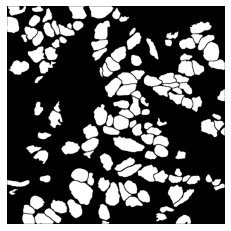

In [86]:
lab = (lab>0)*255
# np.unique(lab)
showtif(lab, verbose=True)
labplane = lab[0]
showtif(labplane,verbose=True)

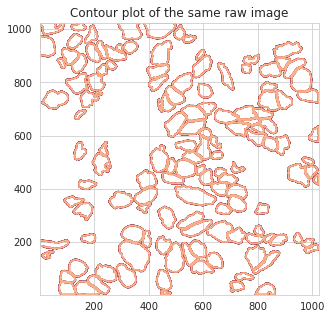

In [87]:
# Contouring
fig, ax = plt.subplots(figsize=(5, 5))
qcs = ax.contour(labplane, origin='image')
ax.set_title('Contour plot of the same raw image')
plt.show()

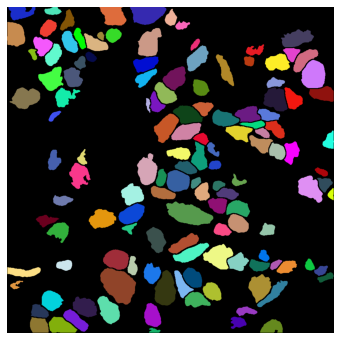

In [88]:
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

labeled = label(labplane)
nlabel = len(np.unique(labeled))
randcols = np.random.random((nlabel, 3))


rgb = color.label2rgb(
    labeled, colors=randcols,bg_label = 0
)
fig, ax = plt.subplots(figsize = (6,6))
plt.axis('off')
plt.imshow(rgb)

In [89]:
labeled

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [90]:
regions = regionprops(labeled)
regions[0].centroid

(19.676529388244703, 42.13274690123951)

(-0.5, 1023.5, 1023.5, -0.5)

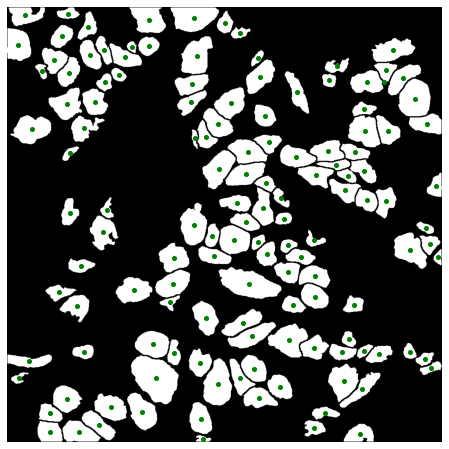

In [91]:
fig, ax = plt.subplots(figsize = (8,8))
ax.imshow(labplane, cmap='gray')

for props in regions:
    y0, x0 = props.centroid
    ax.plot(x0, y0, ".g", markersize=8)
plt.axis('off')

In [92]:
props = measure.regionprops_table(labeled, properties=('label','centroid','area','perimeter',
                                                       'minor_axis_length',
                                                       # 'slice',
                                                       # 'bbox'
                                                       ))
propframe = pd.DataFrame(props)
propframe

,label,centroid-0,centroid-1,area,perimeter,minor_axis_length
0,1,19.676529,42.132747,2501,263.095454,44.301070
1,2,15.119641,143.576271,1003,137.982756,25.334512
2,3,29.330467,332.954913,3837,274.752309,61.405076
3,4,25.054054,438.927995,4958,304.409163,60.761961
4,5,38.407521,513.166539,1303,148.852814,35.511400
...,...,...,...,...,...,...
130,131,1001.512674,168.898606,3156,239.444697,47.967462
131,132,990.447328,722.987023,1310,172.953319,36.748776
132,133,1000.286013,99.754906,2395,194.426407,48.984120
133,134,1004.708410,830.231516,2164,213.438600,42.036342


(-0.5, 1023.5, 1023.5, -0.5)

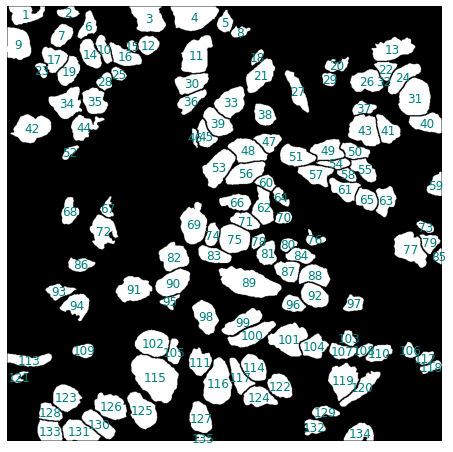

In [93]:
fig, ax = plt.subplots(figsize = (8,8))
ax.imshow(labplane, cmap='gray')

for i in propframe.index:
    x = propframe.iloc[i]["centroid-0"]
    y = propframe.iloc[i]["centroid-1"]
    # text = str(round(propframe.iloc[i]["label"],0))
    text = propframe.iloc[i]["label"].astype(int)
    ax.text(y, x, text, dict(color='teal', va='center', ha='center', size = 12))
plt.axis('off')

### Create Reference Dictionaries and Apply Cell Labeling to Each Stack

In [94]:
# Create a nested dictionary from a single image that contains the input image, the labeled image, and the region properties of the labeled image as a dataframe for each zstack within the image.
origdict={}
labdict={}
imgdict={}
dfdict={}
for i in range(lab.shape[0]):
    singlez = lab[i]
    labeled = measure.label(singlez)
    props = measure.regionprops_table(labeled, properties=('label','centroid','minor_axis_length','area','perimeter'))
    propframe = pd.DataFrame(props)
    slicename = 'z'+str(i)
    dfdict[slicename]=propframe
    imgdict[slicename]=singlez
    labdict[slicename]=labeled
origdict["images"]=imgdict
origdict["labels"]=labdict
origdict["props"]=dfdict
origdict.keys()

dict_keys(['images', 'labels', 'props'])

In [95]:
origdict["images"].keys()

dict_keys(['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6'])

In [96]:
origdict['props']["z1"].head()

,label,centroid-0,centroid-1,minor_axis_length,area,perimeter
0,1,13.575533,141.545876,25.966528,1079,140.225397
1,2,28.009455,334.177976,58.862836,3596,262.024387
2,3,24.153106,438.253281,58.294479,4572,293.338095
3,4,19.471068,41.632621,43.953912,2575,259.681241
4,5,44.628095,189.987621,39.248510,1858,202.409163


(-0.5, 1023.5, 1023.5, -0.5)

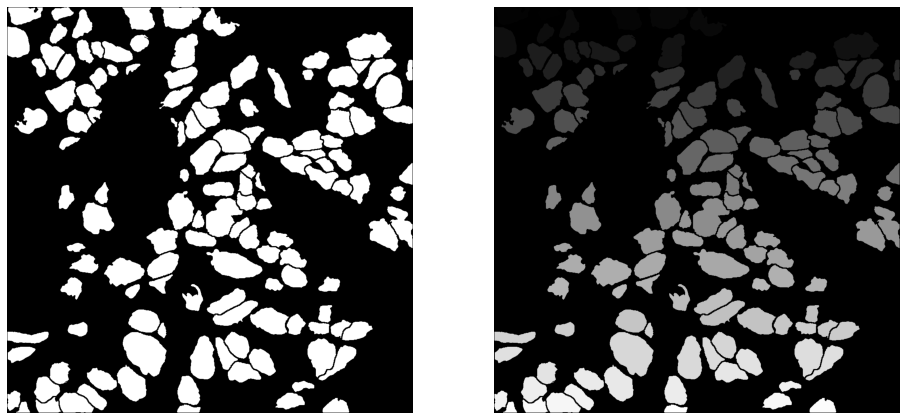

In [97]:
fig, ax = plt.subplots(1,2,figsize = (16,8))
ax[0].imshow(origdict['images']['z2'],cmap='gray')
ax[0].axis('off')
ax[1].imshow(origdict['labels']['z2'],cmap = 'gray')
ax[1].axis('off')

### Compare Cell Labeling

(-0.5, 1023.5, 1023.5, -0.5)

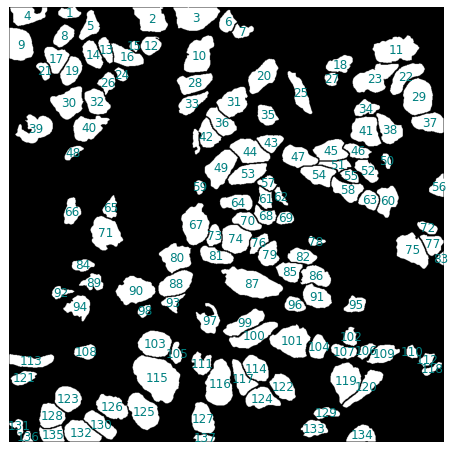

In [98]:
fig, ax = plt.subplots(figsize = (8,8))
ax.imshow(origdict["images"]["z1"], cmap='gray')

for i in origdict["props"]["z1"].index:
    x = origdict["props"]["z1"].iloc[i]["centroid-0"]
    y = origdict["props"]["z1"].iloc[i]["centroid-1"]
    # text = str(round(propframe.iloc[i]["label"],0))
    text = origdict["props"]["z1"].iloc[i]["label"].astype(int)
    ax.text(y, x, text, dict(color='teal', va='center', ha='center', size = 12))
plt.axis('off')

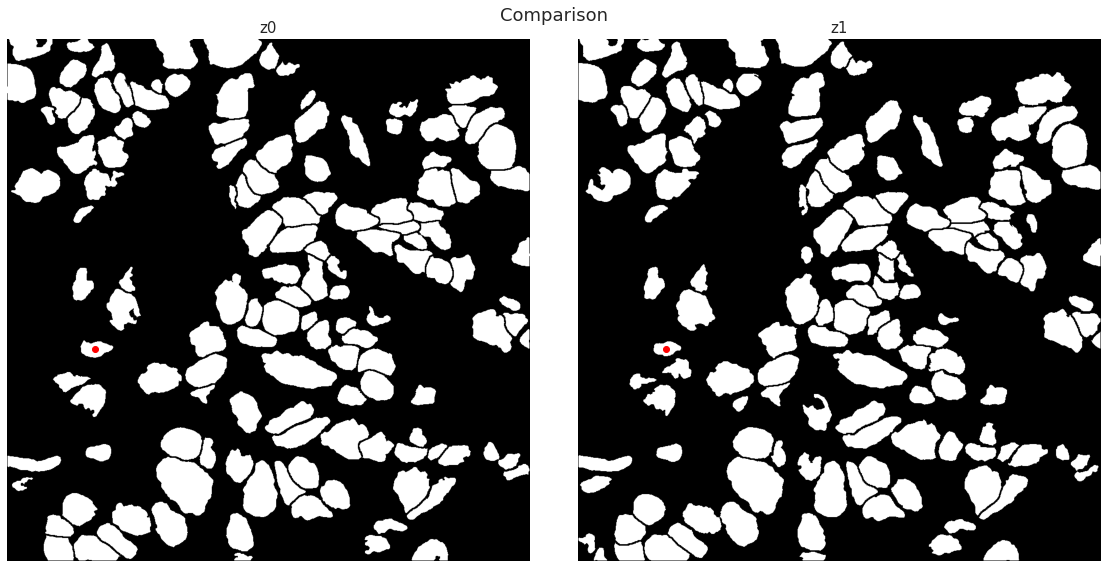

In [99]:
# Picking a random label to ensure it can be tracked between planes
speclabel = 86

fig, ax = plt.subplots(1,2,figsize = (16,8))
ax[0].imshow(labplane, cmap='gray')
y = origdict["props"]["z0"][origdict["props"]["z0"].label == speclabel]["centroid-0"]
x = origdict["props"]["z0"][origdict["props"]["z0"].label == speclabel]["centroid-1"]
ax[0].axis('off')
ax[0].plot(x, y, ".r", markersize=12)
ax[0].set_title("z0",fontdict={'fontsize':15})
ax[1].imshow(origdict["images"]["z1"], cmap='gray')
ax[1].plot(x, y, ".r", markersize=12)
ax[1].set_title("z1",fontdict={'fontsize':15})
ax[1].axis('off')
fig.suptitle('Comparison', fontsize=18)
plt.tight_layout()

In [100]:
dists = {}
for i in origdict["props"]["z1"].index:
    y0 = origdict["props"]["z0"][origdict["props"]["z0"].label == speclabel]["centroid-0"]
    x0 = origdict["props"]["z0"][origdict["props"]["z0"].label == speclabel]["centroid-1"]
    y1 = origdict["props"]["z1"].iloc[i]["centroid-0"]
    x1 = origdict["props"]["z1"].iloc[i]["centroid-1"]
    labdist = math.sqrt(((x1-x0)**2)+((y1-y0)**2))
    label = origdict["props"]["z1"].iloc[i]["label"]
    dists[label]=labdist
# dists.items()

<AxesSubplot:ylabel='Count'>

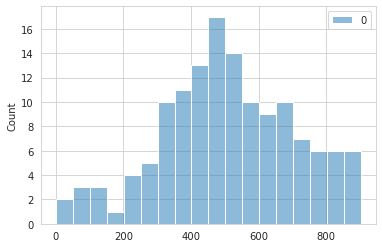

In [101]:
# Histogram of distances from the label of interest
sns.histplot(data=dists.values(), binwidth=50)

In [102]:
# Get minimum values
min(dists.values())

key_list = list(dists.keys())
val_list=list(dists.values())

val_list.sort()
val_list

[0.9612816927551745,
 46.8452074087421,
 81.7153706330866,
 93.6621135614729,
 97.51384299602694,
 129.12801162631374,
 137.31144290535218,
 150.77433565334528,
 180.1561541596336,
 203.4017112748395,
 221.4433083099941,
 224.0234231713778,
 229.14611787666857,
 251.61155490564502,
 255.23124143586128,
 267.70736369321685,
 282.95310684328894,
 298.72310300067244,
 302.58016749822696,
 314.87233101548634,
 315.0284686746392,
 317.19422535327715,
 318.54233224432136,
 324.74882039733643,
 325.1108044904734,
 331.6606363098626,
 340.1140486132781,
 340.36190933729847,
 361.5176403066485,
 363.7781424555904,
 365.96884320750604,
 371.898592500808,
 376.76670117164065,
 384.5484077917893,
 386.71202683880745,
 392.50263269134325,
 393.73586784928654,
 398.67167284248916,
 399.5621887354522,
 401.02994649182557,
 404.26952104659875,
 405.77101685180696,
 407.3727781425631,
 417.53157728889755,
 420.4005177606702,
 423.84569501090186,
 426.63035127286815,
 435.36195984267,
 436.2225775700903

In [103]:
# Return the corresponding labels of the 5 points with the shortest distances
closelabels = get_key(dists,val_list[0:5])
closelabels

[84.0, 89.0, 92.0, 71.0, 94.0]

In [104]:
# Label with shortest distance
get_key(dists,min(val_list))

84.0

In [105]:
origdict["props"]["z1"][origdict["props"]["z1"].label.isin(closelabels)]

,label,centroid-0,centroid-1,minor_axis_length,area,perimeter
70,71,532.131926,226.571600,69.646623,4169,278.007143
83,84,607.649186,172.807414,26.918994,1106,139.982756
88,89,647.693314,197.803779,37.744732,1376,181.681241
91,92,671.466830,120.249386,26.135366,814,142.811183
93,94,705.613516,164.205830,52.832354,2264,220.551299


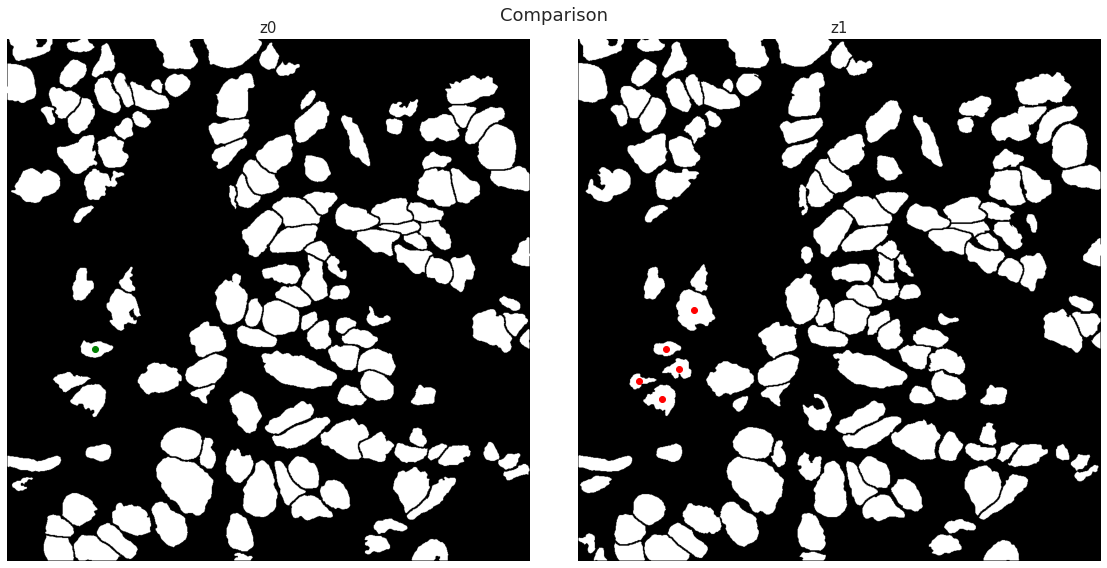

In [106]:

fig, ax = plt.subplots(1,2,figsize = (16,8))
ax[0].imshow(origdict["images"]["z0"], cmap='gray')
y0 = origdict["props"]["z0"][origdict["props"]["z0"].label == speclabel]["centroid-0"]
x0 = origdict["props"]["z0"][origdict["props"]["z0"].label == speclabel]["centroid-1"]
y1 = origdict["props"]["z1"][origdict["props"]["z1"].label.isin(closelabels)]["centroid-0"]
x1 = origdict["props"]["z1"][origdict["props"]["z1"].label.isin(closelabels)]["centroid-1"]
ax[0].axis('off')
ax[0].plot(x0, y0, ".g", markersize=12)
ax[0].set_title("z0",fontdict={'fontsize':15})
ax[1].imshow(origdict["images"]["z1"], cmap='gray')

ax[1].plot(x1, y1, ".r", markersize=12)
ax[1].set_title("z1",fontdict={'fontsize':15})
ax[1].axis('off')
fig.suptitle('Comparison', fontsize=18)
plt.tight_layout()

### Change the labels to the nearest one
1. Create a map for the second layer of the closest centroids from the first layer for each second layer centroid.
2. Remap each label in the second layer to the nearest neighbor of the first.

Things to consider:
   - Case if label either appears or disappears between images/how to catch that.
     - Use a region property as a stand in for radius to set a lower distance for other centroids (minor axis length or perimeter?)
   - Case if two labels are within another label (like an arborized cell).

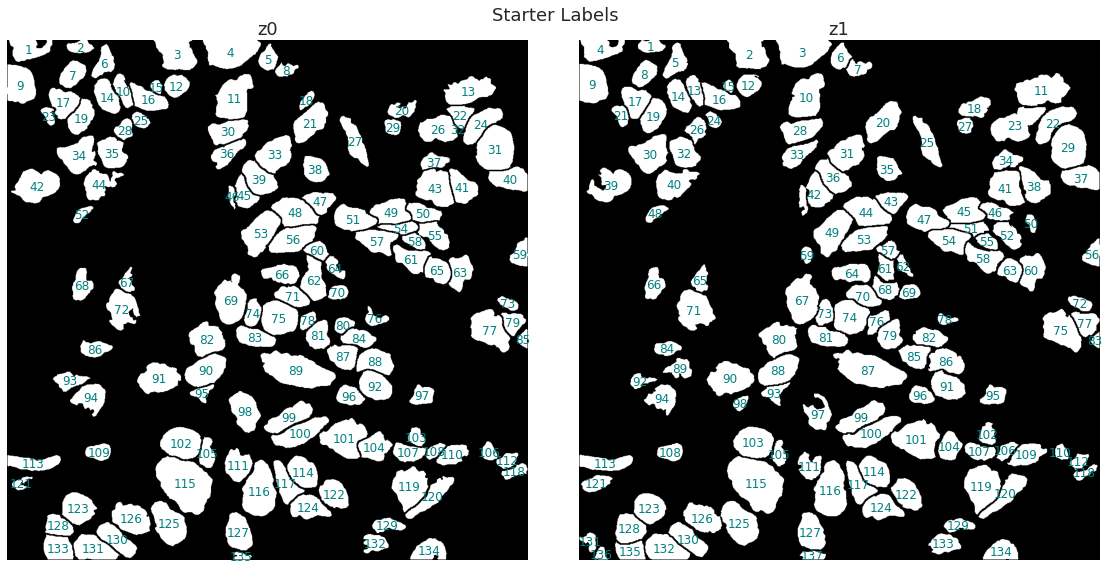

In [107]:
# Starter labels
fig, ax = plt.subplots(1,2,figsize = (16,8))
ax[0].imshow(origdict["images"]["z0"], cmap='gray')
for i in origdict["props"]["z0"].index:
    x = origdict["props"]["z0"].iloc[i]["centroid-0"]
    y = origdict["props"]["z0"].iloc[i]["centroid-1"]
    text = origdict["props"]["z0"].iloc[i]["label"].astype(int)
    ax[0].text(y, x, text, dict(color='teal', va='center', ha='center', size = 12))
ax[0].axis('off')
ax[0].set_title("z0",fontdict={'fontsize':18})
ax[1].imshow(origdict["images"]["z1"], cmap='gray')
for i in origdict["props"]["z1"].index:
    x = origdict["props"]["z1"].iloc[i]["centroid-0"]
    y = origdict["props"]["z1"].iloc[i]["centroid-1"]
    text = origdict["props"]["z1"].iloc[i]["label"].astype(int)
    ax[1].text(y, x, text, dict(color='teal', va='center', ha='center', size = 12))
ax[1].axis('off')
ax[1].set_title("z1",fontdict={'fontsize':18})

fig.suptitle('Starter Labels', fontsize=18)
plt.tight_layout()

In [108]:
# Move through the properties df of the second layer and rename each label based on the closest label from the first layer

# labeldf = pd.DataFrame(origdict['props']['z1']['label'].copy())
newlabels = []

for i in origdict["props"]['z1'].index:
    # Go through each label in the frame the you want to change
    origlabel = origdict["props"]["z1"].iloc[i]["label"]
    y1 = origdict["props"]["z1"].iloc[i]["centroid-0"]
    x1 = origdict["props"]["z1"].iloc[i]["centroid-1"]
    dists = {}
    for j in origdict["props"]['z0'].index:
        y0 = origdict["props"]["z0"].iloc[j]["centroid-0"]
        x0 = origdict["props"]["z0"].iloc[j]["centroid-1"]
        labdist = math.sqrt(((x1-x0)**2)+((y1-y0)**2))
        reflabel = origdict["props"]["z0"].iloc[j]["label"]
        dists[reflabel]=labdist
   # Currently just inheriting the label of the closest centroid from the previous layer. Can be improved with more parameters.
    closestlab = min(list(dists.values()))
    newlabels.append(get_key(dists,closestlab))
# newlabels

In [109]:
newdict = copy.deepcopy(origdict)
newdict.keys()

dict_keys(['images', 'labels', 'props'])

In [110]:
# newdict['props'] = dfdict.copy()
newdict['props']['z1'].label=newlabels
newdict['props']['z1'].label=newdict['props']['z1'].label.astype(int)
newdict['props']['z1']
# origdict['props']['z1']

,label,centroid-0,centroid-1,minor_axis_length,area,perimeter
0,2,13.575533,141.545876,25.966528,1079,140.225397
1,3,28.009455,334.177976,58.862836,3596,262.024387
2,4,24.153106,438.253281,58.294479,4572,293.338095
3,1,19.471068,41.632621,43.953912,2575,259.681241
4,6,44.628095,189.987621,39.248510,1858,202.409163
...,...,...,...,...,...,...
132,132,991.909910,717.766329,38.449284,1776,179.681241
133,134,1006.267258,830.596647,40.707781,2028,189.882251
134,133,1006.420129,101.261556,36.862959,1709,180.704581
135,133,1012.040767,42.846523,22.065501,417,89.112698


In [111]:
print(len(origdict['props']["z0"].label.unique()), "labels for z0")
print(len(origdict['props']['z1'].label.unique()), "labels for z1")
print(len(newdict['props']['z1'].label.unique()), "labels for updated z1")

135 labels for z0
137 labels for z1
130 labels for updated z1


### Apply the new labels to the images

(-0.5, 1023.5, 1023.5, -0.5)

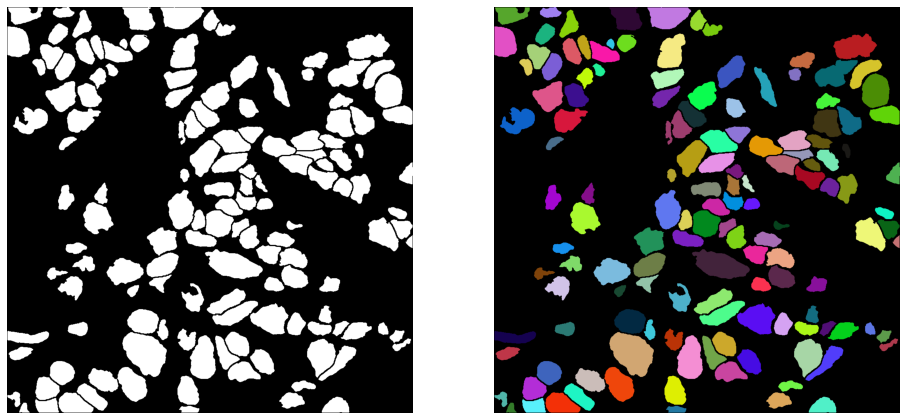

In [112]:
nlabel = len(np.unique(origdict['labels']['z1']))
randcols = np.random.random((nlabel, 3))
origrgb = color.label2rgb(origdict['labels']['z1'], colors=randcols,bg_label = 0)

fig, ax = plt.subplots(1,2,figsize = (16,8))
ax[0].imshow(origdict['images']['z1'],cmap='gray')
ax[0].axis('off')
ax[1].imshow(origrgb)
ax[1].axis('off')

In [113]:
# Go through and change the values in the labeled image to those of the new labels.
# Can directly copy the original label image or create an array of zeros of the same shape to see if there are any parts that dont get picked up.
newdict['labels']['z1'] = np.zeros(origdict['labels']['z1'].shape)
# showtif(newdict['labels']['z1'])

In [114]:
for i in newdict['props']['z1'].index:
    old = origdict['props']['z1'].iloc[i]['label']
    new = newdict['props']['z1'].iloc[i]['label']
    newdict['labels']['z1'] = np.where(origdict['labels']['z1']==old,new,newdict['labels']['z1'])

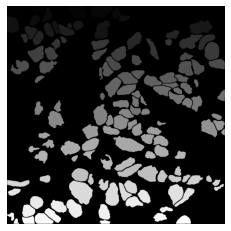

In [115]:
showtif(newdict['labels']['z1'])

### Compare the image labels

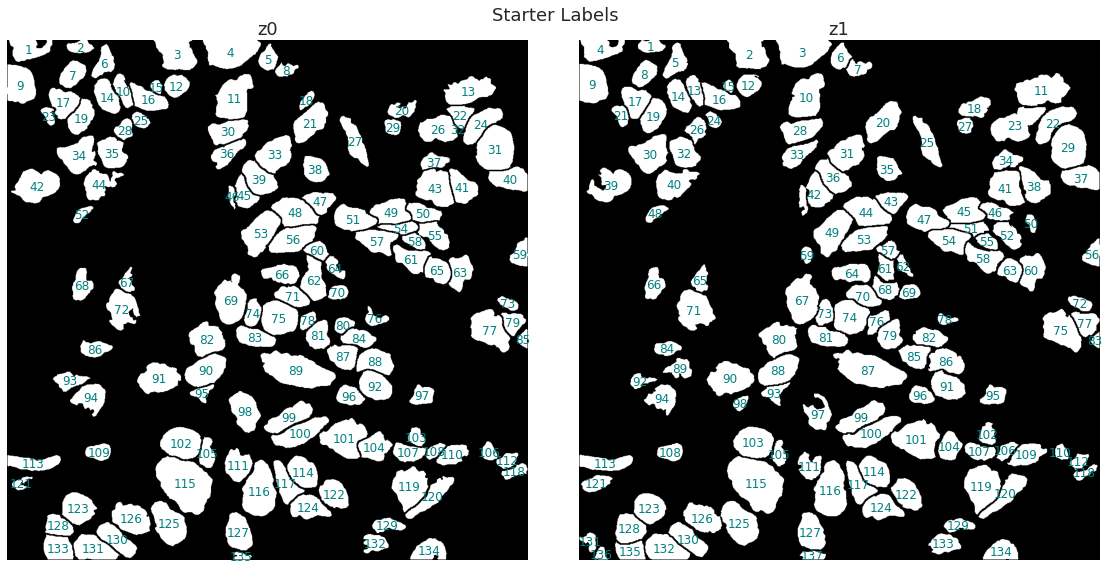

In [116]:
# Starter labels
fig, ax = plt.subplots(1,2,figsize = (16,8))
ax[0].imshow(origdict['images']["z0"], cmap='gray')
for i in origdict['props']["z0"].index:
    x = origdict['props']["z0"].iloc[i]["centroid-0"]
    y = origdict['props']["z0"].iloc[i]["centroid-1"]
    text = origdict['props']["z0"].iloc[i]["label"].astype(int)
    ax[0].text(y, x, text, dict(color='teal', va='center', ha='center', size = 12))
ax[0].axis('off')
ax[0].set_title("z0",fontdict={'fontsize':18})
ax[1].imshow(origdict['images']["z1"], cmap='gray')
for i in origdict['props']["z1"].index:
    x = origdict['props']["z1"].iloc[i]["centroid-0"]
    y = origdict['props']["z1"].iloc[i]["centroid-1"]
    text = origdict['props']["z1"].iloc[i]["label"].astype(int)
    ax[1].text(y, x, text, dict(color='teal', va='center', ha='center', size = 12))
ax[1].axis('off')
ax[1].set_title("z1",fontdict={'fontsize':18})

fig.suptitle('Starter Labels', fontsize=18)
plt.tight_layout()

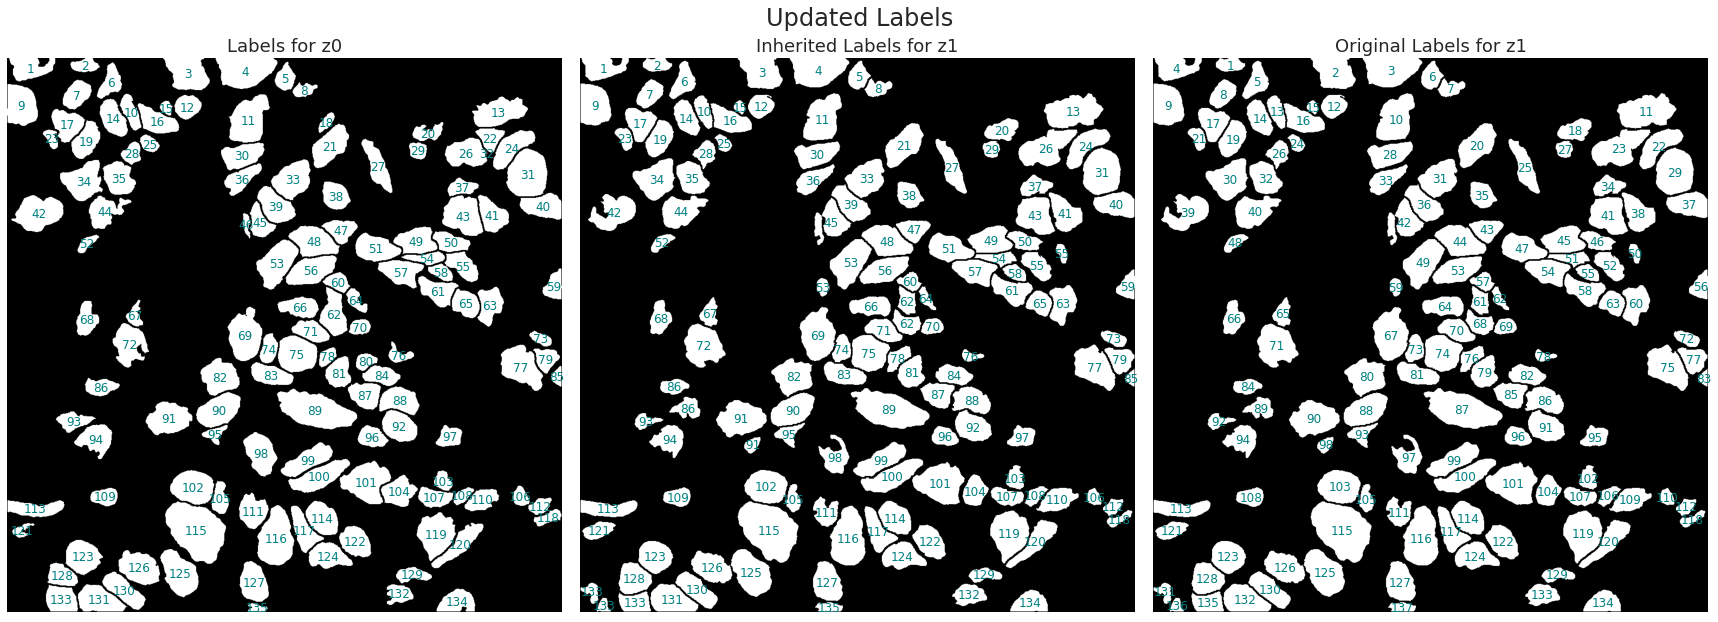

In [117]:
# Changed labels
fig, ax = plt.subplots(1,3,figsize = (24,9))
ax[0].imshow(origdict['images']["z0"], cmap='gray')
for i in origdict['props']["z0"].index:
    x = origdict['props']["z0"].iloc[i]["centroid-0"]
    y = origdict['props']["z0"].iloc[i]["centroid-1"]
    text = origdict['props']["z0"].iloc[i]["label"].astype(int)
    ax[0].text(y, x, text, dict(color='teal', va='center', ha='center', size = 12))
ax[0].axis('off')
ax[0].set_title("Labels for z0",fontdict={'fontsize':18})
ax[1].imshow(newdict['images']["z1"], cmap='gray')
for i in newdict['props']["z1"].index:
    x = newdict['props']['z1'].iloc[i]["centroid-0"]
    y = newdict['props']["z1"].iloc[i]["centroid-1"]
    text = newdict['props']["z1"].iloc[i]["label"].astype(int)
    ax[1].text(y, x, text, dict(color='teal', va='center', ha='center', size = 12))
ax[1].axis('off')
ax[1].set_title("Inherited Labels for z1",fontdict={'fontsize':18})
ax[2].imshow(origdict['images']["z1"], cmap='gray')
for i in origdict['props']["z1"].index:
    x = origdict['props']["z1"].iloc[i]["centroid-0"]
    y = origdict['props']["z1"].iloc[i]["centroid-1"]
    text = origdict['props']["z1"].iloc[i]["label"].astype(int)
    ax[2].text(y, x, text, dict(color='teal', va='center', ha='center', size = 12))
ax[2].axis('off')
ax[2].set_title("Original Labels for z1",fontdict={'fontsize':18})

fig.suptitle('Updated Labels', fontsize=24)
plt.tight_layout()

In [118]:
# Colored labels
# First need to pull all labels from each image to make sure enough colors are created.
uniquelabs = []
for i in newdict['props'].keys():
    for j in np.unique(newdict['props'][i].label):
        uniquelabs.append(j)
uniquelabs = np.unique(uniquelabs)

len(uniquelabs)

136

In [119]:
# Create the color map for all of the unique labels.
randcols = np.random.random((len(uniquelabs), 3))
# Set background labels as 0
randcols[0] = 0

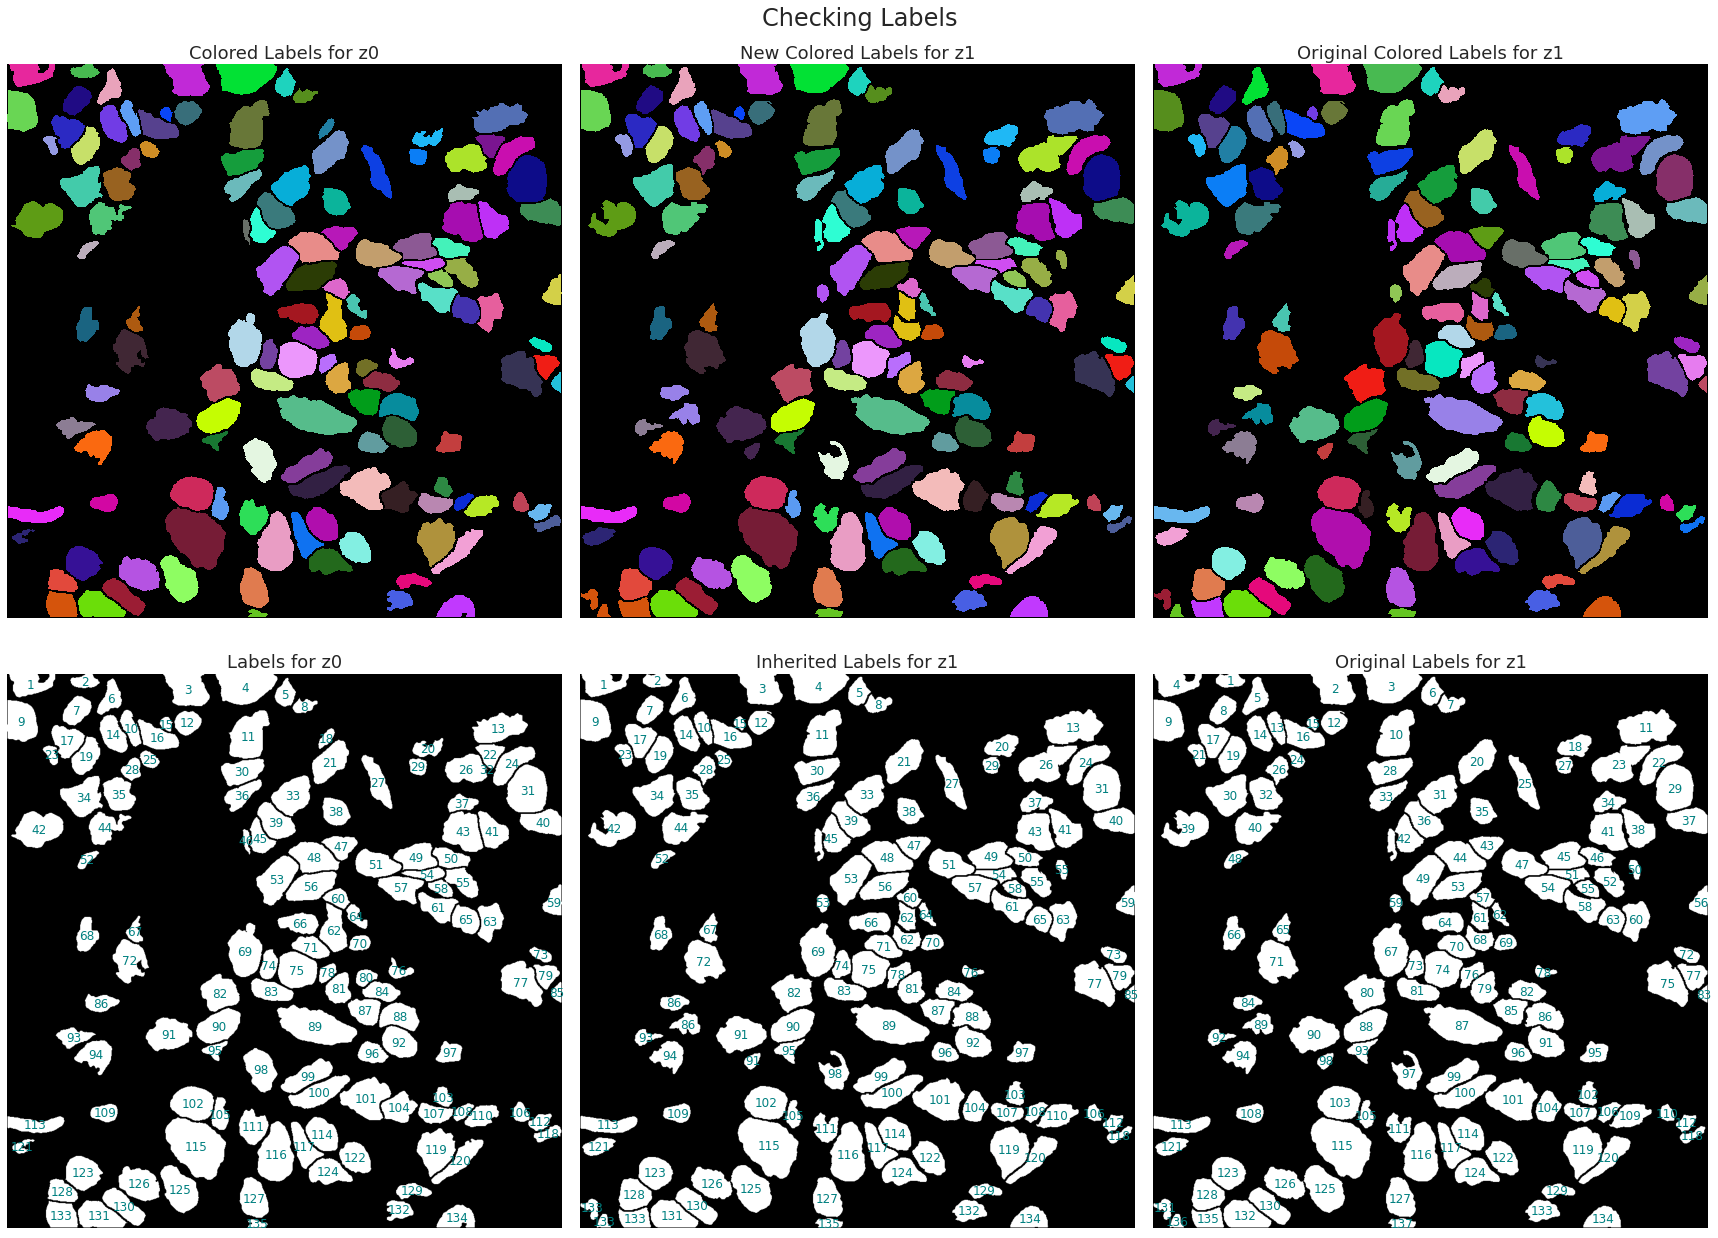

In [120]:
# Problem is that the program will move through the colors above when the image is being instead of using the label values. There is not cell labeled as #18 in z1 for the example below. The color that gets attributed to that cell in z0 gets attributed to the next cell in z1.
# Solved by using matplotlib.imshow to make a colormap out of the random colors and pulling from there.


fig, ax = plt.subplots(2,3,figsize = (24,18))

ax[0,0].imshow(origdict['labels']['z0'],cmap=matplotlib.colors.ListedColormap(randcols),interpolation = 'nearest')
ax[0,0].axis('off')
ax[0,0].set_title("Colored Labels for z0",fontdict={'fontsize':18})
ax[0,1].imshow(newdict['labels']['z1'],cmap=matplotlib.colors.ListedColormap(randcols),interpolation = 'nearest')
ax[0,1].axis('off')
ax[0,1].set_title("New Colored Labels for z1",fontdict={'fontsize':18})
ax[0,2].imshow(origdict['labels']['z1'],cmap=matplotlib.colors.ListedColormap(randcols),interpolation = 'nearest')
ax[0,2].axis('off')
ax[0,2].set_title("Original Colored Labels for z1",fontdict={'fontsize':18})

ax[1,0].imshow(origdict['images']["z0"], cmap='gray')
for i in origdict['props']["z0"].index:
    x = origdict['props']["z0"].iloc[i]["centroid-0"]
    y = origdict['props']["z0"].iloc[i]["centroid-1"]
    text = origdict['props']["z0"].iloc[i]["label"].astype(int)
    ax[1,0].text(y, x, text, dict(color='teal', va='center', ha='center', size = 12))
ax[1,0].axis('off')
ax[1,0].set_title("Labels for z0",fontdict={'fontsize':18})
ax[1,1].imshow(newdict['images']["z1"], cmap='gray')
for i in newdict['props']["z1"].index:
    x = newdict['props']['z1'].iloc[i]["centroid-0"]
    y = newdict['props']["z1"].iloc[i]["centroid-1"]
    text = newdict['props']["z1"].iloc[i]["label"].astype(int)
    ax[1,1].text(y, x, text, dict(color='teal', va='center', ha='center', size = 12))
ax[1,1].axis('off')
ax[1,1].set_title("Inherited Labels for z1",fontdict={'fontsize':18})
ax[1,2].imshow(origdict['images']["z1"], cmap='gray')
for i in origdict['props']["z1"].index:
    x = origdict['props']["z1"].iloc[i]["centroid-0"]
    y = origdict['props']["z1"].iloc[i]["centroid-1"]
    text = origdict['props']["z1"].iloc[i]["label"].astype(int)
    ax[1,2].text(y, x, text, dict(color='teal', va='center', ha='center', size = 12))
ax[1,2].axis('off')
ax[1,2].set_title("Original Labels for z1",fontdict={'fontsize':18})

fig.suptitle('Checking Labels', fontsize=24)
plt.tight_layout()

## Vesion 1 POCs

### All z-stacks from one image

In [121]:
# Make an empty dictionary to capture the data
v1dict = copy.deepcopy(origdict)
v1dict.keys()

dict_keys(['images', 'labels', 'props'])

In [122]:
# Move through each z-stack of the image and name the labels based on those in the previous label.
for z in range(len(list(origdict['images'].keys()))):
    currentz = list(origdict['images'].keys())[z]
    previousz = list(origdict['images'].keys())[z-1]
    # Nothing to do for first z layer
    if currentz=='z0':
        continue
    newlabels = []
    for i in origdict["props"][currentz].index:
        # Go through each label in the frame the you want to change
        origlabel = v1dict["props"][currentz].iloc[i]["label"]
        y1 = v1dict["props"][currentz].iloc[i]["centroid-0"]
        x1 = v1dict["props"][currentz].iloc[i]["centroid-1"]
        dists = {}
        for j in v1dict["props"][previousz].index:
            y0 = v1dict["props"][previousz].iloc[j]["centroid-0"]
            x0 = v1dict["props"][previousz].iloc[j]["centroid-1"]
            labdist = math.sqrt(((x1-x0)**2)+((y1-y0)**2))
            reflabel = v1dict["props"][previousz].iloc[j]["label"]
            dists[reflabel]=labdist
        # Currently just inheriting the label of the closest centroid from the previous layer. Can be improved with more parameters.
        closestlab = min(list(dists.values()))
        newlabels.append(get_key(dists,closestlab))
    # Add the new labels to the region properties table
    v1dict['props'][currentz].label=newlabels
    v1dict['props'][currentz].label=v1dict['props'][currentz].label.astype(int)
    # Change the labels in the new dictionary
    v1dict['labels'][currentz] = np.zeros(origdict['labels'][currentz].shape)
    for i in v1dict['props'][currentz].index:
        old = origdict['props'][currentz].iloc[i]['label']
        new = v1dict['props'][currentz].iloc[i]['label']
        v1dict['labels'][currentz] = np.where(origdict['labels'][currentz]==old,new,v1dict['labels'][currentz])

In [123]:
uniquelabs = []
for i in v1dict['props'].keys():
    for j in np.unique(v1dict['props'][i].label):
        uniquelabs.append(j)
uniquelabs = np.unique(uniquelabs)

# Create the color map for all of the unique labels.
randcols = np.random.random((len(uniquelabs), 3))
# Set background labels as 0
randcols[0] = 0

len(uniquelabs)

135

Text(0.5, 1.0, 'New Colored Labels for z6')

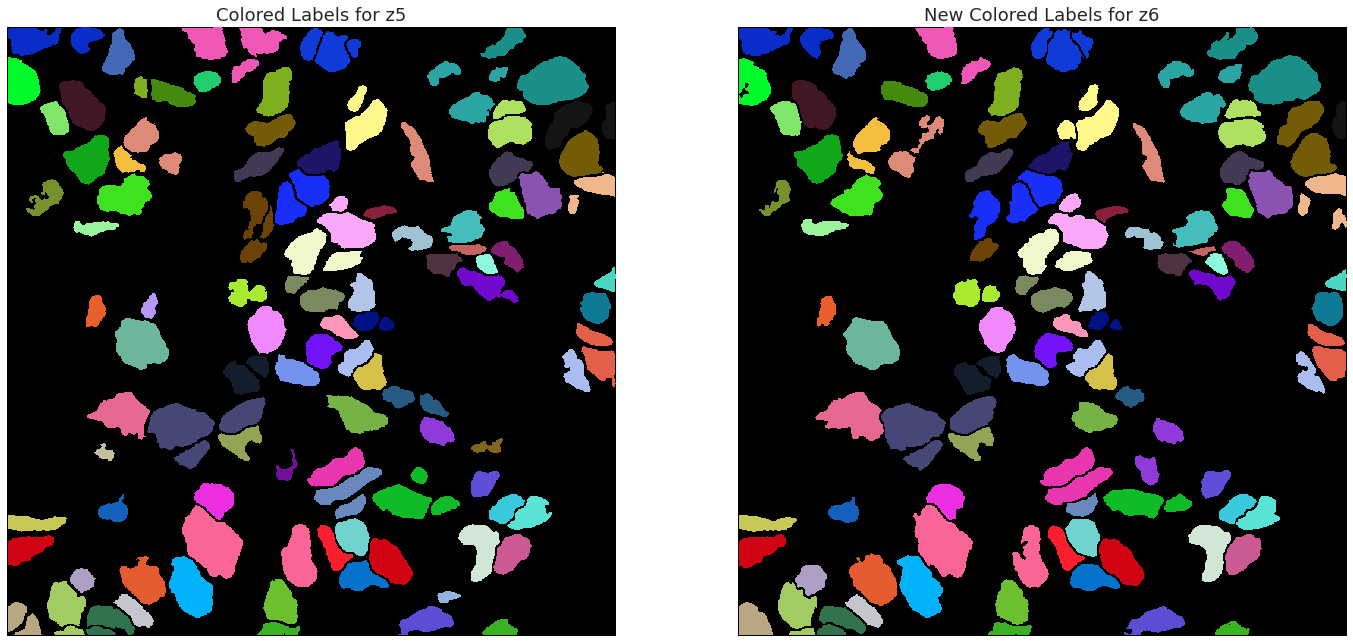

In [124]:
startz = 5
firstim = 'z'+str(startz)
secondim = 'z'+str(startz+1)
fig, ax = plt.subplots(1,2,figsize = (24,18))
ax[0].imshow(v1dict['labels'][firstim],cmap=matplotlib.colors.ListedColormap(randcols),interpolation = 'nearest')
ax[0].axis('off')
ax[0].set_title(f"Colored Labels for {firstim}",fontdict={'fontsize':18})
ax[1].imshow(v1dict['labels'][secondim],cmap=matplotlib.colors.ListedColormap(randcols),interpolation = 'nearest')
ax[1].axis('off')
ax[1].set_title(f"New Colored Labels for {secondim}",fontdict={'fontsize':18})

In [125]:
filenames = []

for i in v1dict['labels']:
    print(i)

z0
z1
z2
z3
z4
z5
z6


In [126]:
# matplotlib.use('Agg')
plt.ioff()

In [127]:
v1dict['labels']['z0'].shape[1]/100

10.24

In [128]:
# Write the rgb labels to arrays for numpy
newlabels = []
for i in v1dict['labels']:
    # fig, ax = plt.subplots(figsize=(10.24,10.24),dpi=100)
    xsize = v1dict['labels'][i].shape[1]/100
    ysize = v1dict['labels'][i].shape[1]/100
    fig, ax = plt.subplots(figsize=(xsize,ysize),dpi=100)
    ax.imshow(v1dict['labels'][i],cmap=matplotlib.colors.ListedColormap(randcols),interpolation = 'nearest')
    ax.axis('off')
    plt.tight_layout(pad=0)
    fig.canvas.draw()
    labz = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    labz = labz.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    newlabels.append(labz)
    plt.close(fig)
newlabeltif = np.stack(newlabels)

In [129]:
newlabeltif.shape

(7, 1024, 1024, 3)

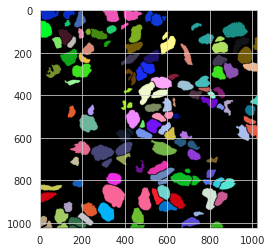

In [130]:
showrgb = newlabeltif[4]
showrgb.shape
plt.imshow(showrgb)

In [131]:
numimages = []
for h in v1dict['images']:
    # fig, ax = plt.subplots(figsize=(10.24,10.24),dpi=100)
    xsize = v1dict['images'][h].shape[1]/100
    ysize = v1dict['images'][h].shape[1]/100
    fig, ax = plt.subplots(figsize=(xsize,ysize),dpi=100)
    ax.imshow(v1dict['images'][h], cmap='gray')
    for i in v1dict['props'][h].index:
        x = v1dict['props'][h].iloc[i]["centroid-0"]
        y = newdict['props'][h].iloc[i]["centroid-1"]
        text = newdict['props'][h].iloc[i]["label"].astype(int)
        ax.text(y, x, text, dict(color='teal', va='center', ha='center', size = 15))
    ax.axis('off')
    plt.tight_layout(pad=0)
    fig.canvas.draw()
    numz = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    numz = numz.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    numimages.append(numz)
    plt.close(fig)
numberedtif = np.stack(numimages)

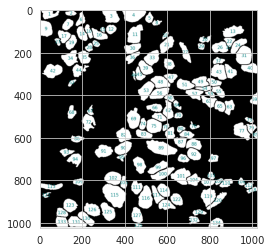

In [132]:
plt.imshow(numberedtif[0])

In [133]:
testgifmaking = False
testgifmaking = True

if testgifmaking:
    # Writing the outputs directly to images
    filenames = []
    for i in v1dict['labels']:
        fig, ax = plt.subplots(figsize=(10.24,10.24))
        ax.imshow(v1dict['labels'][i],cmap=matplotlib.colors.ListedColormap(randcols),interpolation = 'nearest')
        ax.axis('off')
        plt.tight_layout(pad=0)

        filename = os.path.join(OUTDIR, f'compare_{i}.tiff')
        filenames.append(filename)
        plt.savefig(filename, dpi=100)
        plt.close()
    # Create a gif from the generated images
    os.chdir(OUTDIR)

    fp_in = "compare_*.tiff"
    fp_out = "compare.gif"
    imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
    img = next(imgs)  # extract first image from iterator
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)
    # Remove all of the images
    for filename in set(filenames):
        os.remove(filename)

#### Testing gifs/interactive figures with plotly

In [134]:
# plotly.io.renderers

In [135]:
# plotly.io.renderers.default = "plotly_mimetype"

In [136]:
# fig = px.imshow(
#     newlabeltif,
#     # facet_col=1,
#     animation_frame=0,
#     # labels={'animation_frame': 'time point', 'facet_col': 'channel'}
# )
# plotly.io.show(fig)

# Functions

In [137]:
# Testing with single image
testimgidx = 1
exampleimage =imgdf['imgfolder'][testimgidx]
labelimage = imgdf['labelpath'][testimgidx]
print(f'Starting with labels from image {exampleimage}')

Starting with labels from image C1-FB323A_CSC_Rd1_2


## CreateLabelDict

### v01

#### Define Function

In [138]:
# Original input image dictionary creator from single image
def CreateLabelDictv01(inputimg):
    # Check if the object passed is a in image or a file
    if os.path.isfile(inputimg):
        zstack = io.imread(inputimg, plugin='tifffile')
    else:
        zstack = inputimg
    origdict={}
    labdict={}
    imgdict={}
    dfdict={}
    for i in range(zstack.shape[0]):
        singlez = zstack[i]
        labeled = measure.label(singlez)
        props = measure.regionprops_table(labeled, properties=('label','centroid','minor_axis_length','area','perimeter'))
        propframe = pd.DataFrame(props)
        slicename = 'z'+str(i)
        dfdict[slicename]=propframe
        imgdict[slicename]=singlez
        labdict[slicename]=labeled
    origdict["images"]=imgdict
    origdict["labels"]=labdict
    origdict["props"]=dfdict
    return origdict

#### Testing

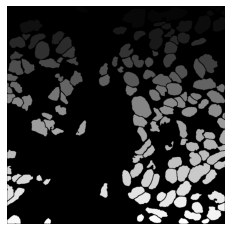

In [139]:

testinputdict = CreateLabelDictv01(labelimage)
testinputdict.keys()
showtif(testinputdict['labels']['z1'])

### v02
- Adds the ability to reverse the images (used to test the CellTracker functions)

#### Define Function

In [140]:
def CreateLabelDictv02(inputimg, reverse_direction = False):
    # Check if the object passed is a in image or a file
    if os.path.isfile(inputimg):
        zstack = io.imread(inputimg, plugin='tifffile')
    else:
        zstack = inputimg

    forward = [*range(zstack.shape[0])]
    reverse = forward.copy()
    reverse.reverse()
    if reverse_direction:
        direction = reverse
    else:
        direction = forward
    origdict={}
    labdict={}
    imgdict={}
    dfdict={}
    counter = 0
    for i in direction:
        singlez = zstack[i]
        labeled = measure.label(singlez)
        props = measure.regionprops_table(labeled, properties=('label','centroid','minor_axis_length','area','perimeter'))
        propframe = pd.DataFrame(props)
        slicename = 'z'+str(counter)
        dfdict[slicename]=propframe
        imgdict[slicename]=singlez
        labdict[slicename]=labeled
        counter += 1
    origdict["images"]=imgdict
    origdict["labels"]=labdict
    origdict["props"]=dfdict
    return origdict

### Example

C1-FB323A_CSC_Rd1_1
dict_keys(['images', 'labels', 'props'])


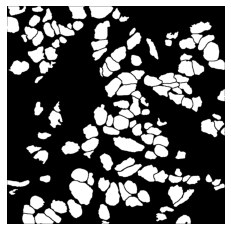

In [141]:
# Test Image
testgroup = imgdf.iloc[[0]].copy()
testgrouptestgroup = imgdf.iloc[[0]].copy()
df = testgroup
for i in df.index:
    imagename = df['imgfolder'][i]
    labelimage = df['labelpath'][i]
    origlabeldict = CreateLabelDictv02(labelimage)

print(imagename)
print(origlabeldict.keys())
showtif(labelimage)

## CellTracker
 - Cell Tracking/Label Updating algorithm
 - scope ends at the creation of a new dictionary, no image or gif creation.

### v01

#### Define Function

In [142]:
def CellTrackerv01(input_dictionary):
    origdict = input_dictionary
    outdict = copy.deepcopy(origdict)
    for z in range(len(list(origdict['images'].keys()))):
        currentz = list(origdict['images'].keys())[z]
        previousz = list(origdict['images'].keys())[z-1]
        # Nothing to do for first z layer
        if currentz=='z0':
            continue
        newlabels = []
        for i in origdict["props"][currentz].index:
            # Go through each label in the frame the you want to change
            origlabel = outdict["props"][currentz].iloc[i]["label"]
            y1 = outdict["props"][currentz].iloc[i]["centroid-0"]
            x1 = outdict["props"][currentz].iloc[i]["centroid-1"]
            dists = {}
            for j in outdict["props"][previousz].index:
                y0 = outdict["props"][previousz].iloc[j]["centroid-0"]
                x0 = outdict["props"][previousz].iloc[j]["centroid-1"]
                labdist = math.sqrt(((x1-x0)**2)+((y1-y0)**2))
                reflabel = outdict["props"][previousz].iloc[j]["label"]
                dists[reflabel]=labdist
            # Currently just inheriting the label of the closest centroid from the previous layer. Can be improved with more parameters.
            closestlab = min(list(dists.values()))
            newlabels.append(get_key(dists,closestlab))
        # Add the new labels to the region properties table
        outdict['props'][currentz].label=newlabels
        outdict['props'][currentz].label=outdict['props'][currentz].label.astype(int)
        # Change the labels in the new dictionary
        outdict['labels'][currentz] = np.zeros(origdict['labels'][currentz].shape)
        for i in outdict['props'][currentz].index:
            old = origdict['props'][currentz].iloc[i]['label']
            new = outdict['props'][currentz].iloc[i]['label']
            outdict['labels'][currentz] = np.where(origdict['labels'][currentz]==old,new,outdict['labels'][currentz])
    return outdict

#### Testing

In [143]:
# Testing with single image
start_time = time.time()
testoutdict = CellTrackerv01(testinputdict)
print("--- %s seconds ---" % round((time.time() - start_time),0))
testoutdict.keys()

--- 32.0 seconds ---


dict_keys(['images', 'labels', 'props'])

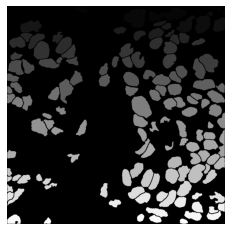

In [144]:
showtif(testoutdict['labels']['z0'])

### v02
- Version 01 cell tracking only utilizes the previous image meaning that if labels are not present in the previous they get attributed to another label.

In [ ]:
def StackCreatorv01(input_dict):
    """Creates a dictionary of tifs based on the labels of the input dictionary. Dictionary needs to contain the keys 'labels', 'props', and 'images'. Use the CreateLabelDict function for this purpose. The returned dictionary contains a tif that is colored only by its label (shaded), a tif with the label number overlaid on top of each stack (numbered), and a tif that is colored based using a randomized colormap (colored)."""
    stackdict = {}
    # Find all of the unique labels contained in all of the label images.
    uniquelabs = []
    for i in input_dict['props'].keys():
        for j in np.unique(input_dict['props'][i].label):
            uniquelabs.append(j)
    uniquelabs = np.unique(uniquelabs)
    # Create the color map for all of the unique labels.
    randcols = np.random.random((len(uniquelabs), 3))
    # Set background labels as 0
    randcols[0] = 0

    # Create a stack of the colored labels
    coloredlabels = []
    for i in input_dict['labels']:
        # Need to label the image, then create a numpy array from that plot.
        # Bizzare figsize and DPI declarations come from plt's method of creating figures, this ensures that the resulting numpy array has the same dimensions as the input image.
        xsize = input_dict['labels'][i].shape[0]/100
        ysize = input_dict['labels'][i].shape[1]/100
        fig, ax = plt.subplots(figsize=(xsize,ysize),dpi=100)
        ax.imshow(input_dict['labels'][i],cmap=matplotlib.colors.ListedColormap(randcols),interpolation = 'nearest')
        ax.axis('off')
        plt.tight_layout(pad=0)
        fig.canvas.draw()
        labz = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        labz = labz.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        coloredlabels.append(labz)
        plt.close(fig)
    coloredstack = np.stack(coloredlabels)

    # Create a stack of the numbered labels
    numlabels = []
    for h in input_dict['images']:
        xsize = input_dict['images'][h].shape[0]/100
        ysize = input_dict['images'][h].shape[1]/100
        fig, ax = plt.subplots(figsize=(xsize,ysize),dpi=100)
        ax.imshow(input_dict['images'][h], cmap='gray')
        for i in input_dict['props'][h].index:
            x = input_dict['props'][h].iloc[i]["centroid-0"]
            y = input_dict['props'][h].iloc[i]["centroid-1"]
            text = input_dict['props'][h].iloc[i]["label"].astype(int)
            ax.text(y, x, text, dict(color='teal', va='center', ha='center', size = 15))
        ax.axis('off')
        plt.tight_layout(pad=0)
        fig.canvas.draw()
        numz = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        numz = numz.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        numlabels.append(numz)
        plt.close(fig)
    numberedstack = np.stack(numlabels)

    # Create a stack of the shaded labels
    shadedlabels =[]
    for i in input_dict['labels']:
        xsize = input_dict['labels'][i].shape[0]/100
        ysize = input_dict['labels'][i].shape[1]/100
        fig, ax = plt.subplots(figsize=(xsize,ysize),dpi=100)
        ax.imshow(input_dict['labels'][i], cmap='gray')
        ax.axis('off')
        plt.tight_layout(pad=0)
        fig.canvas.draw()
        shadez = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        shadez = shadez.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        shadedlabels.append(shadez)
        plt.close(fig)
        # shadedlabels.append(input_dict['labels'][i])
    shadedstack = np.stack(shadedlabels)

    # Save the outputs together to a dictionary.
    stackdict['shaded']=shadedstack
    stackdict['colored']=coloredstack
    stackdict['numbered']=numberedstack
    return stackdict

#### Pieces

##### Look at single image

Starting with labels from image C1-FB323A_CSC_Rd1_5


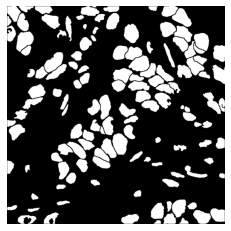

In [145]:
refidx = 4
exampleimage =imgdf['imgfolder'][refidx]
lab = imgdf['labelpath'][refidx]
print(f'Starting with labels from image {exampleimage}')
showtif(lab)

In [146]:
origdict = CreateLabelDictv01(lab)
origlabeldict = StackCreatorv01(origdict)
origlabeldict.keys()

NameError: name 'StackCreatorv01' is not defined

In [ ]:
startidx = 0
endidx= 1
startz = 'z'+str(startidx)
endz = 'z'+str(endidx)

fig, ax = plt.subplots(1, 2,figsize=(20,10))
ax[0].imshow(origlabeldict['numbered'][startidx])
ax[1].imshow(origlabeldict['numbered'][endidx])
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title("labels in first image:"+str(len(origdict['props'][startz].label)))
ax[1].set_title("labels in second image:"+str(len(origdict['props'][endz].label)))

##### Investigate alternate methods for label propagation

In [ ]:
# See if the the start label overlays the next label.
# Example of label with clear overlap in the next image but different label ids
speclabel = 133
startbinarray = origdict['labels'][startz]==speclabel
overlappinglabels = startbinarray*origdict['labels'][endz]
overlapid = np.unique(overlappinglabels)[1:]
print(f'Label {speclabel} from {startz} overlaps with {len(overlapid)} label(s) from {endz}: {overlapid}')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
showtif(startbinarray)
plt.subplot(1,2,2)
showtif(overlappinglabels)

In [ ]:
# Example of label with no cell in the next image (shrinking)
speclabel = 131
startbinarray = origdict['labels'][startz]==speclabel
overlappinglabels = startbinarray*origdict['labels'][endz]
overlapid = np.unique(overlappinglabels)[1:]
print(f'Label {speclabel} from {startz} overlaps with {len(overlapid)} label(s) from {endz}: {overlapid}')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
showtif(startbinarray)
plt.subplot(1,2,2)
showtif(overlappinglabels)

In [ ]:
# Example of cell not present in first image that is present in next image (growing)
# Looking the other direction
speclabel = 73
# startbinarray = origdict['labels'][startz]==speclabel
endbinarray = origdict['labels'][endz]==speclabel
overlappinglabels = endbinarray*origdict['labels'][startz]
overlapid = np.unique(overlappinglabels)[1:]
print(f'Label {speclabel} from {endz} overlaps with {len(overlapid)} label(s) from {startz}: {overlapid}')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
showtif(endbinarray)
plt.subplot(1,2,2)
showtif(overlappinglabels)

In [ ]:
# Example of two labels that join to one (joining)
# Looking the other direction
speclabel = 87
# startbinarray = origdict['labels'][startz]==speclabel
endbinarray = origdict['labels'][endz]==speclabel
overlappinglabels = endbinarray*origdict['labels'][startz]
overlapid = np.unique(overlappinglabels)[1:]
print(f'Label {speclabel} from {endz} overlaps with {len(overlapid)} label(s) from {startz}: {overlapid}')

# speclabel = 81
# startbinarray = origdict['labels'][startz]==speclabel
# overlappinglabels = startbinarray*origdict['labels'][endz]
# overlapid = np.unique(overlappinglabels)[1:]
# print(f'Label {speclabel} from {startz} overlaps with {len(overlapid)} label(s) from {endz}: {overlapid}')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
showtif(endbinarray)
plt.subplot(1,2,2)
showtif(overlappinglabels)

In [ ]:
# Example of one label that splits into one (splitting)
speclabel = 15
startbinarray = origdict['labels'][startz]==speclabel
overlappinglabels = startbinarray*origdict['labels'][endz]
overlapid = np.unique(overlappinglabels)[1:]
print(f'Label {speclabel} from {startz} overlaps with {len(overlapid)} label(s) from {endz}: {overlapid}')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
showtif(startbinarray)
plt.subplot(1,2,2)
showtif(overlappinglabels)

##### Putting together a solution

In [ ]:
origdict = CreateLabelDictv01(lab)

In [ ]:
# Make a new dictionary to hold the new labels
newdict = copy.deepcopy(origdict)
newdict.keys()
len(newdict['props']['z0'])

In [ ]:
# Filter out all labels with area less than 50
for i in newdict['labels'].keys():
    newdict['props'][i] = newdict['props'][i][newdict['props'][i].area>50]
    newdict['props'][i]=newdict['props'][i].reset_index(drop=True)
len(newdict['props']['z0'])
# newdict['props']['z0']

In [ ]:
# Make unique label ids for each label across the stack.
labids = pd.DataFrame()
zlayers = []
zlabel = []
uniqueid = []
counter = 0
for i in newdict['props']:
    for j in newdict['props'][i].label:
        zlayers.append(i)
        zlabel.append(j)
        # concat = str(i)+"-"+str(j)
        counter+=1
        uniqueid.append(counter)
labids['zlayer']=zlayers
labids['zlabel']=zlabel
labids['uid']=uniqueid
labids

In [ ]:
# i = 263
# zlayer = labids.iloc[i]['zlayer']
# zlabel = labids.iloc[i]['zlabel']
# uid = labids.iloc[i]['uid']
# showtif(newdict['labels'][zlayer]==zlabel)
# newdict['labels'][zlayer][newdict['labels'][zlayer]==zlabel]=uid
# showtif(newdict['labels'][zlayer]==uid)

In [ ]:
# Change the regionproperties for each image and the labels for each to the new value (corresponding index of the labid frame)
for i in labids.index:
    zlayer = labids.iloc[i]['zlayer']
    zlabel = labids.iloc[i]['zlabel']
    uid = labids.iloc[i]['uid']
    # Change the label in the props table
    corridx = newdict['props'][zlayer].label[newdict['props'][zlayer].label==zlabel].index.tolist()[0]
    newdict['props'][zlayer].at[corridx,'label']=uid
    # Change the label value in the image.
    newdict['labels'][zlayer][newdict['labels'][zlayer]==zlabel]=uid
    # print(zlayer,zlabel,corridx)

In [ ]:
newdict['props']['z1']

In [ ]:
updatedlabs = StackCreatorv01(newdict)
updatedlabs.keys()

In [ ]:
startidx = 0
endidx= 1
startz = 'z'+str(startidx)
endz = 'z'+str(endidx)

fig, ax = plt.subplots(1, 2,figsize=(20,10))
ax[0].imshow(updatedlabs['numbered'][startidx])
ax[1].imshow(updatedlabs['numbered'][endidx])
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title("labels in first image:"+str(len(newdict['props'][startz].label)))
ax[1].set_title("labels in second image:"+str(len(newdict['props'][endz].label)))

In [ ]:
# Create a dataframe to keep track of label changes
labchangedf = pd.DataFrame()
labchangedf['startzlabels'] = newdict['props'][startz].label
labchangedf.insert(1,'endzoverlaps',0)
labchangedf.insert(2,'action',"none")
labchangedf['endzoverlaps']=labchangedf['endzoverlaps'].astype(object)
labchangedf

In [ ]:
# Move through each label and see if it overlaps with labels in the following layer. Add those labels to the changed label column.
# Changed labels == 0 represent ones that do not have corresponding labels from the previous layer and suggest a growing cell. These need to be assigned to labels which are unique to the entire stack as they represent a new cell.
# Multiple original labels with the same changed label suggest a cell that is joining. These need to have the labels from the previous layer changed. (Maybe this needs to be done backwards)

for i in newdict['props'][startz].label:
    speclabel=i
    startbinarray = newdict['labels'][startz]==speclabel
    overlappinglabels = startbinarray*newdict['labels'][endz]
    overlapid = np.unique(overlappinglabels)[1:]
    labelindex = labchangedf.index[labchangedf['startzlabels']==i].tolist()[0]
    labchangedf.at[labelindex,"endzoverlaps"]=overlapid
    # print(overlapid)

In [ ]:
labchangedf

In [ ]:
for i in labchangedf.index:
    if len(labchangedf.iloc[i]['endzoverlaps'])==0:
        labchangedf.at[i,'action']='shrinking'
    if len(labchangedf.iloc[i]['endzoverlaps'])==1:
        labchangedf.at[i,'action']='update'
    if len(labchangedf.iloc[i]['endzoverlaps'])>1:
        labchangedf.at[i,'action']='branching'

labchangedf

In [ ]:
# Check for duplicates
# labchangedf.endzoverlaps.duplicated(keep=False)
allvals = []
for i in labchangedf.index:
    for j in labchangedf.iloc[i]['endzoverlaps']:
        allvals.append(j)
# allvals

In [ ]:
# Get a list of repeated labels
from collections import Counter
d = Counter(allvals)
d = dict((k, v) for k, v in d.items() if v > 1)
replabs = list(d.keys())
# replabs
# d

In [ ]:
# Update the list based on repeated values.
for i in labchangedf.index:
    for j in labchangedf.iloc[i]['endzoverlaps']:
        if j in replabs:
            labchangedf.loc[i,'action']='repeats'
labchangedf

In [ ]:
# For repeats, use centroid to determine label from the end z
repeats = labchangedf[labchangedf.action=='repeats']
repeats = repeats.reset_index(drop=True)
repeats.insert(2,'startzchanges',np.nan)
repeats

In [ ]:
# Startz labels inheriting the label from the same image based on centroids.
newlabels = []
# startlabelrepeats=[]
for i in replabs:
    startlabelrepeats=[]
    for j in repeats.index:
        if i in repeats.iloc[j]['endzoverlaps']:
            startlabelrepeats.append(repeats.iloc[j]['startzlabels'])
    # Measure the distance to the end label for each shorter label and take the shorter one.
    dists = {}
    y1 = int(newdict["props"][endz][newdict["props"][endz].label==i]["centroid-0"])
    x1 = int(newdict["props"][endz][newdict["props"][endz].label==i]["centroid-1"])
    for j in startlabelrepeats:
        y0 = int(newdict["props"][startz][newdict["props"][startz].label==j]["centroid-0"])
        x0 = int(newdict["props"][startz][newdict["props"][startz].label==j]["centroid-1"])
        labdist = math.sqrt(((x1-x0)**2)+((y1-y0)**2))
        dists[j]=labdist
    closestdist = min(list(dists.values()))
    closestlab = get_key(dists,closestdist)
    for j in repeats.index:
        if repeats.iloc[j]['startzlabels'] in startlabelrepeats:
            if np.isnan(repeats.iloc[j]['startzchanges']):
                repeats.at[j,'startzchanges']=int(closestlab)


    # for j in startlabelrepeats:
    #     newlabels.append(closestlab)
    # print(i,startlabelrepeats,closestlab)

# repeats.startzchanges = newlabels
repeats

In [ ]:
# Go through and use centroid to find the correct label
newlabels = []
for i in repeats.index:
    origlabel = repeats.iloc[i]['startzlabels']
    y1 = newdict["props"][startz][newdict["props"][startz].label==origlabel]["centroid-0"]
    x1 = newdict["props"][startz][newdict["props"][startz].label==origlabel]["centroid-1"]
    dists = {}
    for j in newdict["props"][endz].index:
        y0 = newdict["props"][endz].iloc[j]["centroid-0"]
        x0 = newdict["props"][endz].iloc[j]["centroid-1"]
        labdist = math.sqrt(((x1-x0)**2)+((y1-y0)**2))
        reflabel = newdict["props"][endz].iloc[j]["label"]
        dists[reflabel]=labdist
    closestlab = min(list(dists.values()))
    newlabels.append(get_key(dists,closestlab))
newlabels
repeats.startzchanges = newlabels
repeats

In [ ]:
# i=2
#
# repind = repeats[repeats.startzlabels==i].index[0]
# newlabel = repeats.loc[repind]['startzchanges']
# origind = newdict['props'][startz][newdict['props'][startz].label==i].index[0]
# # newdict['props'][startz].at[origind,'label']=newlabel
# print(origind)

In [ ]:
# Change the start z value to the new value.
for i in repeats.startzlabels:
    repind = repeats[repeats.startzlabels==i].index[0]
    newlabel = repeats.loc[repind]['startzchanges']
    origind = newdict['props'][startz][newdict['props'][startz].label==i].index[0]
    newdict['props'][startz].at[origind,'label']=newlabel
    # Update the label image as well.
    newdict['labels'][startz][newdict['labels'][startz]==i]=newlabel
    # print(repind)

In [ ]:
newdict['props'][startz].label

In [ ]:
# Check if it worked
updatedlabs = StackCreatorv01(newdict)
updatedlabs.keys()

In [ ]:
startidx = 0
endidx= 1
startz = 'z'+str(startidx)
endz = 'z'+str(endidx)

fig, ax = plt.subplots(1, 2,figsize=(20,10))
ax[0].imshow(updatedlabs['numbered'][startidx])
ax[1].imshow(updatedlabs['numbered'][endidx])
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title("labels in first image:"+str(len(newdict['props'][startz].label)))
ax[1].set_title("labels in second image:"+str(len(newdict['props'][endz].label)))

In [ ]:
# Update the remaining labels forward
nextchanges = labchangedf[(labchangedf.action=='update')|(labchangedf.action=='branching')]
nextchanges = nextchanges.reset_index(drop=True)
nextchanges

In [ ]:
for i in nextchanges.index:
    newlabel = nextchanges.iloc[i]['startzlabels']
    for j in nextchanges.iloc[i]['endzoverlaps']:
        origlabel = j
        try:
            origind = newdict['props'][endz][newdict['props'][endz].label==j].index[0]
            # print(origind)
            newdict['props'][endz].at[origind,'label']=newlabel
            newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel
        except:
            continue
        # print(newdict['props'][endz][newdict['props'][endz].label==j].index)for i in nextchanges.index:
    newlabel = nextchanges.iloc[i]['startzlabels']
    for j in nextchanges.iloc[i]['endzoverlaps']:
        origlabel = j
        try:
            origind = newdict['props'][endz][newdict['props'][endz].label==j].index[0]
            # print(origind)
            newdict['props'][endz].at[origind,'label']=newlabel
            newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel
        except:
            continue
        # print(newdict['props'][endz][newdict['props'][endz].label==j].index)

In [ ]:
newdict['props'][endz]

In [ ]:
updatedlabs = StackCreatorv01(newdict)
updatedlabs.keys()

In [ ]:
startidx = 0
endidx= 1
startz = 'z'+str(startidx)
endz = 'z'+str(endidx)

fig, ax = plt.subplots(1, 2,figsize=(20,10))
ax[0].imshow(updatedlabs['numbered'][startidx])
ax[1].imshow(updatedlabs['numbered'][endidx])
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title("labels in first image:"+str(len(newdict['props'][startz].label)))
ax[1].set_title("labels in second image:"+str(len(newdict['props'][endz].label)))

#### Define Function

In [ ]:
def CellTrackerv02(input_dictionary):
    origdict = input_dictionary
    newdict = copy.deepcopy(origdict)
    # Filter out all labels with area less than 50
    for i in newdict['labels'].keys():
        # ALSO NEED TO REMOVE THE LABELS.
        newdict['props'][i] = newdict['props'][i][newdict['props'][i].area>50]
        newdict['props'][i]=newdict['props'][i].reset_index(drop=True)
    labids = pd.DataFrame()
    zlayers = []
    zlabel = []
    uniqueid = []
    counter = 0
    for i in newdict['props']:
        for j in newdict['props'][i].label:
            zlayers.append(i)
            zlabel.append(j)
            counter+=1
            uniqueid.append(counter)
    labids['zlayer']=zlayers
    labids['zlabel']=zlabel
    labids['uid']=uniqueid
    # Change the regionproperties for each image and the labels for each to the new value (corresponding index of the labid frame)
    for i in labids.index:
        zlayer = labids.iloc[i]['zlayer']
        zlabel = labids.iloc[i]['zlabel']
        uid = labids.iloc[i]['uid']
        # Change the label in the props table
        corridx = newdict['props'][zlayer].label[newdict['props'][zlayer].label==zlabel].index.tolist()[0]
        newdict['props'][zlayer].at[corridx,'label']=uid
        # Change the label value in the image.
        newdict['labels'][zlayer][newdict['labels'][zlayer]==zlabel]=uid
    for z in range(len(list(newdict['props'].keys()))):
        if z ==6:
            continue
        startz = list(newdict['props'].keys())[z]
        endz = list(newdict['props'].keys())[z+1]
        # Create a dataframe to keep track of label changes, fill it with the properties of the end labels
        labchangedf = pd.DataFrame()
        labchangedf['startzlabels'] = newdict['props'][startz].label
        labchangedf.insert(1,'endzoverlaps',0)
        labchangedf.insert(2,'action',"none")
        labchangedf['endzoverlaps']=labchangedf['endzoverlaps'].astype(object)
        # Move through each label and see if it overlaps with labels in the following layer. Add those labels to the changed label column.
        # Changed labels == 0 represent ones that do not have corresponding labels from the previous layer and suggest a growing cell. These need to be assigned to labels which are unique to the entire stack as they represent a new cell.
        # Multiple original labels with the same changed label suggest a cell that is joining. These need to have the labels from the previous layer changed. (Maybe this needs to be done backwards)
        for i in newdict['props'][startz].label:
            speclabel=i
            startbinarray = newdict['labels'][startz]==speclabel
            overlappinglabels = startbinarray*newdict['labels'][endz]
            overlapid = np.unique(overlappinglabels)[1:]
            labelindex = labchangedf.index[labchangedf['startzlabels']==i].tolist()[0]
            labchangedf.at[labelindex,"endzoverlaps"]=overlapid
        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'
        # Check for duplicates
        # labchangedf.endzoverlaps.duplicated(keep=False)
        allvals = []
        for i in labchangedf.index:
            for j in labchangedf.iloc[i]['endzoverlaps']:
                allvals.append(j)
        # Get a list of repeated labels
        from collections import Counter
        d = Counter(allvals)
        d = dict((k, v) for k, v in d.items() if v > 1)
        replabs = list(d.keys())
        # Update the list based on repeated values.
        for i in labchangedf.index:
            for j in labchangedf.iloc[i]['endzoverlaps']:
                if j in replabs:
                    labchangedf.loc[i,'action']='repeats'
        repeats = labchangedf[labchangedf.action=='repeats']
        repeats = repeats.reset_index(drop=True)
        repeats.insert(2,'startzchanges',np.nan)
        # Go through and use centroid to find the correct label
        newlabels = []
        for i in repeats.index:
            origlabel = repeats.iloc[i]['startzlabels']
            y1 = newdict["props"][startz][newdict["props"][startz].label==origlabel]["centroid-0"]
            x1 = newdict["props"][startz][newdict["props"][startz].label==origlabel]["centroid-1"]
            dists = {}
            for j in newdict["props"][endz].index:
                y0 = newdict["props"][endz].iloc[j]["centroid-0"]
                x0 = newdict["props"][endz].iloc[j]["centroid-1"]
                labdist = math.sqrt(((x1-x0)**2)+((y1-y0)**2))
                reflabel = newdict["props"][endz].iloc[j]["label"]
                dists[reflabel]=labdist
            closestlab = min(list(dists.values()))
            newlabels.append(get_key(dists,closestlab))
        repeats.startzchanges = newlabels
        # Change the start z value to the new value.
        for i in repeats.startzlabels:
            repind = repeats[repeats.startzlabels==i].index[0]
            newlabel = repeats.loc[repind]['startzchanges']
            origind = newdict['props'][startz][newdict['props'][startz].label==i].index[0]
            newdict['props'][startz].at[origind,'label']=newlabel
            # Update the label image as well.
            newdict['labels'][startz][newdict['labels'][startz]==i]=newlabel
        # Update the remaining labels forward
        nextchanges = labchangedf[(labchangedf.action=='update')|(labchangedf.action=='branching')]
        nextchanges = nextchanges.reset_index(drop=True)
        for i in nextchanges.index:
            newlabel = nextchanges.iloc[i]['startzlabels']
        for j in nextchanges.iloc[i]['endzoverlaps']:
            origlabel = j
            try:
                origind = newdict['props'][endz][newdict['props'][endz].label==j].index[0]
                # print(origind)
                newdict['props'][endz].at[origind,'label']=newlabel
                newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel
            except:
                continue
    return newdict

#### Testing

In [ ]:
# Testing with single image
testimgidx = 3
exampleimage =imgdf['imgfolder'][testimgidx]
labelimage = imgdf['labelpath'][testimgidx]
print(f'Starting with labels from image {exampleimage}')

testinputdict = CreateLabelDictv01(labelimage)
testinputdict.keys()
showtif(testinputdict['labels']['z1'])

In [ ]:
# Testing with single image
start_time = time.time()
testoutdict = CellTrackerv02(testinputdict)
print("--- %s seconds ---" % round((time.time() - start_time),0))
testoutlabels = StackCreatorv01(testoutdict)

In [ ]:
showtif(testoutlabels['shaded'][2],verbose=True)
plt.imshow(testoutlabels['colored'][2])
# plt.imshow(testoutlabels['numbered'][0])
# plt.imshow(testoutlabels['shaded'][0])

### v03

#### Pieces

In [ ]:
refidx = 0
exampleimage =imgdf['imgfolder'][refidx]
lab = imgdf['labelpath'][refidx]
lab = io.imread(lab, plugin='tifffile')
print(f'Starting with labels from image {exampleimage}')

origdict = CreateLabelDictv01(lab)

# Make a new dictionary to hold the new labels
newdict = copy.deepcopy(origdict)
# newdict.keys()

In [ ]:
startz = 'z0'
endz = 'z1'

In [ ]:
# Filter out all labels with area less than 50
for i in newdict['labels'].keys():
    for j in newdict['props'][i][newdict['props'][i].area<50]['label']:
        newdict['labels'][i][newdict['labels'][i]==j]=0
    newdict['props'][i] = newdict['props'][i][newdict['props'][i].area>50]
    newdict['props'][i] = newdict['props'][i].reset_index(drop=True)

# # Printout to check if it worked.
# for i in newdict['labels'].keys():
#     toosmall = len(origdict['props'][i][origdict['props'][i].area<50])
#     numorig = len(np.unique(origdict['labels'][i]))
#     numnew = len(np.unique(newdict['labels'][i]))
#     print(f'Layer {i} has {toosmall} labels smaller than 50. Original image has {numorig}, new image has {numnew}.')

In [ ]:
# Make unique label ids for each label across the stack.
labids = pd.DataFrame()
zlayers = []
zlabel = []
uniqueid = []
counter = 0
for i in newdict['props']:
    for j in newdict['props'][i].label:
        zlayers.append(i)
        zlabel.append(j)
        # concat = str(i)+"-"+str(j)
        counter+=1
        uniqueid.append(counter)
labids['zlayer']=zlayers
labids['zlabel']=zlabel
labids['uid']=uniqueid

# Change the regionproperties for each image and the labels for each to the new value (corresponding index of the labid frame)
for i in labids.index:
    zlayer = labids.iloc[i]['zlayer']
    zlabel = labids.iloc[i]['zlabel']
    uid = labids.iloc[i]['uid']
    # Change the label in the props table
    corridx = newdict['props'][zlayer].label[newdict['props'][zlayer].label==zlabel].index.tolist()[0]
    newdict['props'][zlayer].at[corridx,'label']=uid
    # Change the label value in the image.
    newdict['labels'][zlayer][newdict['labels'][zlayer]==zlabel]=uid

# Create a dataframe to keep track of label changes
labchangedf = pd.DataFrame()
labchangedf['startzlabels'] = newdict['props'][startz].label
labchangedf.insert(1,'endzoverlaps',0)
labchangedf.insert(2,'action',"none")
labchangedf['endzoverlaps']=labchangedf['endzoverlaps'].astype(object)

# Move through each label and see if it overlaps with labels in the following layer. Add those labels to the changed label column.
# Changed labels == 0 represent ones that do not have corresponding labels from the previous layer and suggest a growing cell. These need to be assigned to labels which are unique to the entire stack as they represent a new cell.
# Multiple original labels with the same changed label suggest a cell that is joining. These need to have the labels from the previous layer changed. (Maybe this needs to be done backwards)
for i in newdict['props'][startz].label:
    speclabel=i
    startbinarray = newdict['labels'][startz]==speclabel
    overlappinglabels = startbinarray*newdict['labels'][endz]
    overlapid = np.unique(overlappinglabels)[1:]
    labelindex = labchangedf.index[labchangedf['startzlabels']==i].tolist()[0]
    labchangedf.at[labelindex,"endzoverlaps"]=overlapid

for i in labchangedf.index:
    if len(labchangedf.iloc[i]['endzoverlaps'])==0:
        labchangedf.at[i,'action']='shrinking'
    if len(labchangedf.iloc[i]['endzoverlaps'])==1:
        labchangedf.at[i,'action']='update'
    if len(labchangedf.iloc[i]['endzoverlaps'])>1:
        labchangedf.at[i,'action']='branching'

# Check for the branching
for i in labchangedf.index:
    if labchangedf.iloc[i]['action']!= 'branching':
        continue
    startlabel = labchangedf.iloc[i]['startzlabels']
    trueoverlaps = []
    startbin = newdict['labels'][startz]==startlabel
    for j in labchangedf.iloc[i]['endzoverlaps']:
        endbin = newdict['labels'][endz]==j
        endarea = newdict['props'][endz][newdict['props'][endz]['label']==j]['area']
        overlap = np.count_nonzero(np.logical_and(startbin,endbin))
        percentoverlap = (overlap/endarea).tolist()
        if (percentoverlap[0])>0.5:
            trueoverlaps.append(j)
    labchangedf.at[i,"endzoverlaps"] = trueoverlaps

for i in labchangedf.index:
    if len(labchangedf.iloc[i]['endzoverlaps'])==0:
        labchangedf.at[i,'action']='shrinking'
    if len(labchangedf.iloc[i]['endzoverlaps'])==1:
        labchangedf.at[i,'action']='update'
    if len(labchangedf.iloc[i]['endzoverlaps'])>1:
        labchangedf.at[i,'action']='branching'

In [ ]:
updatedlabs = StackCreatorv01(newdict)
startidx = 0
endidx= 1
startz = 'z'+str(startidx)
endz = 'z'+str(endidx)

fig, ax = plt.subplots(1, 2,figsize=(20,10))
ax[0].imshow(updatedlabs['numbered'][startidx])
ax[1].imshow(updatedlabs['numbered'][endidx])
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title("labels in first image:"+str(len(newdict['props'][startz].label)))
ax[1].set_title("labels in second image:"+str(len(newdict['props'][endz].label)))

In [ ]:
# Check for duplicates
# labchangedf.endzoverlaps.duplicated(keep=False)
allvals = []
for i in labchangedf.index:
    for j in labchangedf.iloc[i]['endzoverlaps']:
        allvals.append(j)
d = Counter(allvals)
d = dict((k, v) for k, v in d.items() if v > 1)
replabs = list(d.keys())
# replabs

In [ ]:
# i = 25
# newlabel = labchangedf.iloc[i]['startzlabels']
# if labchangedf.iloc[i]['action']=='shrinking':
#     print('continue')
# for j in labchangedf.iloc[i]['endzoverlaps']:
#     origlabel = j
#     if origlabel in replabs:
#        print('repeat')
#        continue
#     origind = newdict['props'][endz][newdict['props'][endz]['label']==j].index.tolist()[0]
#     # newdict['props'][endz].at[origind,'label']=newlabel
#     # newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel
#     print(origind)

In [ ]:
for i in labchangedf.index:
    newlabel = labchangedf.iloc[i]['startzlabels']
    if labchangedf.iloc[i]['action']=='shrinking':
        continue
    for j in labchangedf.iloc[i]['endzoverlaps']:
        origlabel = j
        if origlabel in replabs:
            continue
        origind = newdict['props'][endz][newdict['props'][endz]['label']==j].index.tolist()[0]
        newdict['props'][endz].at[origind,'label']=newlabel
        newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel

In [ ]:
updatedlabs = StackCreatorv01(newdict)
startidx = 5
endidx= 6
startz = 'z'+str(startidx)
endz = 'z'+str(endidx)

fig, ax = plt.subplots(1, 2,figsize=(20,10))
ax[0].imshow(updatedlabs['numbered'][startidx])
ax[1].imshow(updatedlabs['numbered'][endidx])
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title("labels in first image:"+str(len(newdict['props'][startz].label)))
ax[1].set_title("labels in second image:"+str(len(newdict['props'][endz].label)))

#### Together
- all pieces run on all stacks of a single image.
- includes the reverse propagation of branching cells.

In [ ]:
refidx = 0
exampleimage =imgdf['imgfolder'][refidx]
lab = imgdf['labelpath'][refidx]
lab = io.imread(lab, plugin='tifffile')
print(f'Starting with labels from image {exampleimage}')

### Start Function

origdict = CreateLabelDictv01(lab)

# Make a new dictionary to hold the new labels
newdict = copy.deepcopy(origdict)

forwardpass =[]
for i in newdict['images'].keys():
    forwardpass.append(i)
reversepass = forwardpass.copy()
reversepass.reverse()

# Filter out all labels with area less than 50
for i in newdict['labels'].keys():
    for j in newdict['props'][i][newdict['props'][i].area<50]['label']:
        newdict['labels'][i][newdict['labels'][i]==j]=0
    newdict['props'][i] = newdict['props'][i][newdict['props'][i].area>50]
    newdict['props'][i]=newdict['props'][i].reset_index(drop=True)

# Make unique label ids for each label across the stack.
labids = pd.DataFrame()
zlayers = []
zlabel = []
uniqueid = []
counter = 0
for i in newdict['props']:
    for j in newdict['props'][i].label:
        zlayers.append(i)
        zlabel.append(j)
        # concat = str(i)+"-"+str(j)
        counter+=1
        uniqueid.append(counter)
labids['zlayer']=zlayers
labids['zlabel']=zlabel
labids['uid']=uniqueid

# Change the regionproperties for each image and the labels for each to the new value (corresponding index of the labid frame)
for i in labids.index:
    zlayer = labids.iloc[i]['zlayer']
    zlabel = labids.iloc[i]['zlabel']
    uid = labids.iloc[i]['uid']
    # Change the label in the props table
    corridx = newdict['props'][zlayer].label[newdict['props'][zlayer].label==zlabel].index.tolist()[0]
    newdict['props'][zlayer].at[corridx,'label']=uid
    # Change the label value in the image.
    newdict['labels'][zlayer][newdict['labels'][zlayer]==zlabel]=uid

for z in forwardpass:
    if z == 'z6':
        continue
    startind = int(list(z)[1])
    startz = z
    endind = int(list(z)[1])+1
    endz = 'z'+str(endind)

    # Create a dataframe to keep track of label changes
    labchangedf = pd.DataFrame()
    labchangedf['startzlabels'] = newdict['props'][startz].label
    labchangedf.insert(1,'endzoverlaps',0)
    labchangedf.insert(2,'action',"none")
    labchangedf['endzoverlaps']=labchangedf['endzoverlaps'].astype(object)

    # Move through each label and see if it overlaps with labels in the following layer. Add those labels to the changed label column.
    # Changed labels == 0 represent ones that do not have corresponding labels from the previous layer and suggest a growing cell. These need to be assigned to labels which are unique to the entire stack as they represent a new cell.
    # Multiple original labels with the same changed label suggest a cell that is joining. These need to have the labels from the previous layer changed. (Maybe this needs to be done backwards)
    for i in newdict['props'][startz].label:
        speclabel=i
        startbinarray = newdict['labels'][startz]==speclabel
        overlappinglabels = startbinarray*newdict['labels'][endz]
        overlapid = np.unique(overlappinglabels)[1:]
        labelindex = labchangedf.index[labchangedf['startzlabels']==i].tolist()[0]
        labchangedf.at[labelindex,"endzoverlaps"]=overlapid
    labchangedf = labchangedf.drop_duplicates(subset=['startzlabels'])
    labchangedf = labchangedf.reset_index(drop=True)
    for i in labchangedf.index:
        if len(labchangedf.iloc[i]['endzoverlaps'])==0:
            labchangedf.at[i,'action']='shrinking'
        if len(labchangedf.iloc[i]['endzoverlaps'])==1:
            labchangedf.at[i,'action']='update'
        if len(labchangedf.iloc[i]['endzoverlaps'])>1:
            labchangedf.at[i,'action']='branching'

    # Check for the branching
    for i in labchangedf.index:
        if labchangedf.iloc[i]['action']!= 'branching':
            continue
        startlabel = labchangedf.iloc[i]['startzlabels']
        trueoverlaps = []
        startbin = newdict['labels'][startz]==startlabel
        for j in labchangedf.iloc[i]['endzoverlaps']:
            endbin = newdict['labels'][endz]==j
            endarea = newdict['props'][endz][newdict['props'][endz]['label']==j]['area']
            overlap = np.count_nonzero(np.logical_and(startbin,endbin))
            percentoverlap = (overlap/endarea).tolist()
            if (percentoverlap[0])>0.5:
                trueoverlaps.append(j)
        labchangedf.at[i,"endzoverlaps"] = trueoverlaps

    for i in labchangedf.index:
        if len(labchangedf.iloc[i]['endzoverlaps'])==0:
            labchangedf.at[i,'action']='shrinking'
        if len(labchangedf.iloc[i]['endzoverlaps'])==1:
            labchangedf.at[i,'action']='update'
        if len(labchangedf.iloc[i]['endzoverlaps'])>1:
            labchangedf.at[i,'action']='branching'

    # Check for duplicates
    allvals = []
    for i in labchangedf.index:
        for j in labchangedf.iloc[i]['endzoverlaps']:
            allvals.append(j)
    d = Counter(allvals)
    d = dict((k, v) for k, v in d.items() if v > 1)
    replabs = list(d.keys())

    # Updating the labels
    for i in labchangedf.index:
        newlabel = labchangedf.iloc[i]['startzlabels']
        if labchangedf.iloc[i]['action']=='shrinking':
            continue
        for j in labchangedf.iloc[i]['endzoverlaps']:
            origlabel = j
            if origlabel in replabs:
                continue
            origind = newdict['props'][endz][newdict['props'][endz]['label']==j].index.tolist()[0]
            newdict['props'][endz].at[origind,'label']=newlabel
            newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel

for z in reversepass:
    if z == 'z0':
        continue
    startz = z
    endind = int(list(z)[1])-1
    endz = 'z'+str(endind)
    # Create a dataframe to keep track of label changes
    labchangedf = pd.DataFrame()
    labchangedf['startzlabels'] = newdict['props'][startz].label
    labchangedf.insert(1,'endzoverlaps',0)
    labchangedf.insert(2,'action',"none")
    labchangedf['endzoverlaps']=labchangedf['endzoverlaps'].astype(object)

    # Move through each label and see if it overlaps with labels in the following layer. Add those labels to the changed label column.
    # Changed labels == 0 represent ones that do not have corresponding labels from the previous layer and suggest a growing cell. These need to be assigned to labels which are unique to the entire stack as they represent a new cell.
    # Multiple original labels with the same changed label suggest a cell that is joining. These need to have the labels from the previous layer changed. (Maybe this needs to be done backwards)
    for i in newdict['props'][startz].label:
        speclabel=i
        startbinarray = newdict['labels'][startz]==speclabel
        overlappinglabels = startbinarray*newdict['labels'][endz]
        overlapid = np.unique(overlappinglabels)[1:]
        labelindex = labchangedf.index[labchangedf['startzlabels']==i].tolist()[0]
        labchangedf.at[labelindex,"endzoverlaps"]=overlapid
    labchangedf = labchangedf.drop_duplicates(subset=['startzlabels'])
    labchangedf = labchangedf.reset_index(drop=True)
    for i in labchangedf.index:
        if len(labchangedf.iloc[i]['endzoverlaps'])==0:
            labchangedf.at[i,'action']='shrinking'
        if len(labchangedf.iloc[i]['endzoverlaps'])==1:
            labchangedf.at[i,'action']='update'
        if len(labchangedf.iloc[i]['endzoverlaps'])>1:
            labchangedf.at[i,'action']='branching'

    # Check for the branching
    for i in labchangedf.index:
        if labchangedf.iloc[i]['action']!= 'branching':
            continue
        startlabel = labchangedf.iloc[i]['startzlabels']
        trueoverlaps = []
        startbin = newdict['labels'][startz]==startlabel
        for j in labchangedf.iloc[i]['endzoverlaps']:
            endbin = newdict['labels'][endz]==j
            endarea = newdict['props'][endz][newdict['props'][endz]['label']==j]['area']
            overlap = np.count_nonzero(np.logical_and(startbin,endbin))
            percentoverlap = (overlap/endarea).tolist()
            if (percentoverlap[0])>0.5:
                trueoverlaps.append(j)
        labchangedf.at[i,"endzoverlaps"] = trueoverlaps

    for i in labchangedf.index:
        if len(labchangedf.iloc[i]['endzoverlaps'])==0:
            labchangedf.at[i,'action']='shrinking'
        if len(labchangedf.iloc[i]['endzoverlaps'])==1:
            labchangedf.at[i,'action']='update'
        if len(labchangedf.iloc[i]['endzoverlaps'])>1:
            labchangedf.at[i,'action']='branching'

    #Subset only to the branching labels in the reverse pass.
    labchangedf = labchangedf[labchangedf['action']=='branching']
    labchangedf = labchangedf.reset_index(drop=True)
    # Check for duplicates
    allvals = []
    for i in labchangedf.index:
        for j in labchangedf.iloc[i]['endzoverlaps']:
            allvals.append(j)
    d = Counter(allvals)
    d = dict((k, v) for k, v in d.items() if v > 1)
    replabs = list(d.keys())

    # Updating the labels
    for i in labchangedf.index:
        newlabel = labchangedf.iloc[i]['startzlabels']
        for j in labchangedf.iloc[i]['endzoverlaps']:
            origlabel = j
            if origlabel in replabs:
                continue
            origind = newdict['props'][endz][newdict['props'][endz]['label']==j].index.tolist()[0]
            newdict['props'][endz].at[origind,'label']=newlabel
            newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel

In [ ]:
labchangedf

In [ ]:
updatedlabs = StackCreatorv01(newdict)

In [ ]:
startidx = 5
endidx= startidx+1
startz = 'z'+str(startidx)
endz = 'z'+str(endidx)

fig, ax = plt.subplots(1, 2,figsize=(20,10))
ax[0].imshow(updatedlabs['numbered'][startidx])
ax[1].imshow(updatedlabs['numbered'][endidx])
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title("labels in first image:"+str(len(newdict['props'][startz].label)))
ax[1].set_title("labels in second image:"+str(len(newdict['props'][endz].label)))

#### Define Function

In [ ]:
def CellTrackerv03(input_dictionary):
    origdict = input_dictionary
    # Make a new dictionary to hold the new labels
    newdict = copy.deepcopy(origdict)

    forwardpass =[]
    for i in newdict['images'].keys():
        forwardpass.append(i)
    reversepass = forwardpass.copy()
    reversepass.reverse()

    # Filter out all labels with area less than 50
    for i in newdict['labels'].keys():
        for j in newdict['props'][i][newdict['props'][i].area<50]['label']:
            newdict['labels'][i][newdict['labels'][i]==j]=0
        newdict['props'][i] = newdict['props'][i][newdict['props'][i].area>50]
        newdict['props'][i]=newdict['props'][i].reset_index(drop=True)

    # Make unique label ids for each label across the stack.
    labids = pd.DataFrame()
    zlayers = []
    zlabel = []
    uniqueid = []
    counter = 0
    for i in newdict['props']:
        for j in newdict['props'][i].label:
            zlayers.append(i)
            zlabel.append(j)
            # concat = str(i)+"-"+str(j)
            counter+=1
            uniqueid.append(counter)
    labids['zlayer']=zlayers
    labids['zlabel']=zlabel
    labids['uid']=uniqueid

    # Change the regionproperties for each image and the labels for each to the new value (corresponding index of the labid frame)
    for i in labids.index:
        zlayer = labids.iloc[i]['zlayer']
        zlabel = labids.iloc[i]['zlabel']
        uid = labids.iloc[i]['uid']
        # Change the label in the props table
        corridx = newdict['props'][zlayer].label[newdict['props'][zlayer].label==zlabel].index.tolist()[0]
        newdict['props'][zlayer].at[corridx,'label']=uid
        # Change the label value in the image.
        newdict['labels'][zlayer][newdict['labels'][zlayer]==zlabel]=uid

    for z in forwardpass:
        if z == 'z6':
            continue
        startind = int(list(z)[1])
        startz = z
        endind = int(list(z)[1])+1
        endz = 'z'+str(endind)

        # Create a dataframe to keep track of label changes
        labchangedf = pd.DataFrame()
        labchangedf['startzlabels'] = newdict['props'][startz].label
        labchangedf.insert(1,'endzoverlaps',0)
        labchangedf.insert(2,'action',"none")
        labchangedf['endzoverlaps']=labchangedf['endzoverlaps'].astype(object)

        # Move through each label and see if it overlaps with labels in the following layer. Add those labels to the changed label column.
        # Changed labels == 0 represent ones that do not have corresponding labels from the previous layer and suggest a growing cell. These need to be assigned to labels which are unique to the entire stack as they represent a new cell.
        # Multiple original labels with the same changed label suggest a cell that is joining. These need to have the labels from the previous layer changed. (Maybe this needs to be done backwards)
        for i in newdict['props'][startz].label:
            speclabel=i
            startbinarray = newdict['labels'][startz]==speclabel
            overlappinglabels = startbinarray*newdict['labels'][endz]
            # Doing this to exclude the background zeros but may be removing true labels when start labels are entirely within the boundaries of the end labels
            overlapid = np.unique(overlappinglabels)[1:]
            labelindex = labchangedf.index[labchangedf['startzlabels']==i].tolist()[0]
            labchangedf.at[labelindex,"endzoverlaps"]=overlapid
        labchangedf = labchangedf.drop_duplicates(subset=['startzlabels'])
        labchangedf = labchangedf.reset_index(drop=True)
        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'

        # Check for the branching
        for i in labchangedf.index:
            if labchangedf.iloc[i]['action']!= 'branching':
                continue
            startlabel = labchangedf.iloc[i]['startzlabels']
            trueoverlaps = []
            startbin = newdict['labels'][startz]==startlabel
            for j in labchangedf.iloc[i]['endzoverlaps']:
                endbin = newdict['labels'][endz]==j
                endarea = newdict['props'][endz][newdict['props'][endz]['label']==j]['area']
                overlap = np.count_nonzero(np.logical_and(startbin,endbin))
                percentoverlap = (overlap/endarea).tolist()
                if (percentoverlap[0])>0.5:
                    trueoverlaps.append(j)
            labchangedf.at[i,"endzoverlaps"] = trueoverlaps

        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'

        # Check for duplicates
        allvals = []
        for i in labchangedf.index:
            for j in labchangedf.iloc[i]['endzoverlaps']:
                allvals.append(j)
        d = Counter(allvals)
        d = dict((k, v) for k, v in d.items() if v > 1)
        replabs = list(d.keys())

        # Updating the labels
        for i in labchangedf.index:
            newlabel = labchangedf.iloc[i]['startzlabels']
            if labchangedf.iloc[i]['action']=='shrinking':
                continue
            for j in labchangedf.iloc[i]['endzoverlaps']:
                origlabel = j
                if origlabel in replabs:
                    continue
                origind = newdict['props'][endz][newdict['props'][endz]['label']==j].index.tolist()[0]
                newdict['props'][endz].at[origind,'label']=newlabel
                newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel

    for z in reversepass:
        if z == 'z0':
            continue
        startz = z
        endind = int(list(z)[1])-1
        endz = 'z'+str(endind)
        # Create a dataframe to keep track of label changes
        labchangedf = pd.DataFrame()
        labchangedf['startzlabels'] = newdict['props'][startz].label
        labchangedf.insert(1,'endzoverlaps',0)
        labchangedf.insert(2,'action',"none")
        labchangedf['endzoverlaps']=labchangedf['endzoverlaps'].astype(object)

        # Move through each label and see if it overlaps with labels in the following layer. Add those labels to the changed label column.
        # Changed labels == 0 represent ones that do not have corresponding labels from the previous layer and suggest a growing cell. These need to be assigned to labels which are unique to the entire stack as they represent a new cell.
        # Multiple original labels with the same changed label suggest a cell that is joining. These need to have the labels from the previous layer changed. (Maybe this needs to be done backwards)
        for i in newdict['props'][startz].label:
            speclabel=i
            startbinarray = newdict['labels'][startz]==speclabel
            overlappinglabels = startbinarray*newdict['labels'][endz]
            overlapid = np.unique(overlappinglabels)[1:]
            labelindex = labchangedf.index[labchangedf['startzlabels']==i].tolist()[0]
            labchangedf.at[labelindex,"endzoverlaps"]=overlapid
        labchangedf = labchangedf.drop_duplicates(subset=['startzlabels'])
        labchangedf = labchangedf.reset_index(drop=True)
        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'
        # Check for the branching
        for i in labchangedf.index:
            if labchangedf.iloc[i]['action']!= 'branching':
                continue
            startlabel = labchangedf.iloc[i]['startzlabels']
            trueoverlaps = []
            startbin = newdict['labels'][startz]==startlabel
            for j in labchangedf.iloc[i]['endzoverlaps']:
                endbin = newdict['labels'][endz]==j
                endarea = newdict['props'][endz][newdict['props'][endz]['label']==j]['area']
                overlap = np.count_nonzero(np.logical_and(startbin,endbin))
                percentoverlap = (overlap/endarea).tolist()
                if (percentoverlap[0])>0.5:
                    trueoverlaps.append(j)
            labchangedf.at[i,"endzoverlaps"] = trueoverlaps

        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'

        # Subset only to the branching labels in the reverse pass.
        # labchangedf = labchangedf[labchangedf['action']=='branching']
        # labchangedf = labchangedf.reset_index(drop=True)
        # Check for duplicates
        allvals = []
        for i in labchangedf.index:
            for j in labchangedf.iloc[i]['endzoverlaps']:
                allvals.append(j)
        d = Counter(allvals)
        d = dict((k, v) for k, v in d.items() if v > 1)
        replabs = list(d.keys())

        # Updating the labels
        for i in labchangedf.index:
            newlabel = labchangedf.iloc[i]['startzlabels']
            newlabel = labchangedf.iloc[i]['startzlabels']
            if labchangedf.iloc[i]['action']=='shrinking':
                continue
            for j in labchangedf.iloc[i]['endzoverlaps']:
                origlabel = j
                if origlabel in replabs:
                    continue
                origind = newdict['props'][endz][newdict['props'][endz]['label']==j].index.tolist()[0]
                newdict['props'][endz].at[origind,'label']=newlabel
                newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel
    return newdict

#### Testing

In [ ]:
# Testing with single image
testimgidx = 5
exampleimage =imgdf['imgfolder'][testimgidx]
labelimage = imgdf['labelpath'][testimgidx]
print(f'Starting with labels from image {exampleimage}')

testinputdict = CreateLabelDictv01(labelimage)
testinputdict.keys()
# showtif(testinputdict['labels']['z1'])

# Testing with single image
start_time = time.time()
testoutdict = CellTrackerv03(testinputdict)
print("--- %s seconds ---" % round((time.time() - start_time),0))
testoutlabels = StackCreatorv01(testoutdict)

for i in testoutlabels.keys():
    labelmethod = i
    outputname = "test"+"_"+labelmethod+"_""label"
    # OutputWriterv01(testoutlabels[i], outputname, OUTDIR)

### v04
- Removing border cells.
- Resetting the labels at the end of the run.
- Remove overlapping IDs.

#### Pieces

In [ ]:
# Test Image
testgroup = imgdf.iloc[[0]].copy()
testgrouptestgroup = imgdf.iloc[[0]].copy()
df = testgroup
for i in df.index:
    imagename = df['imgfolder'][i]
    labelimage = df['labelpath'][i]
    origlabeldict = CreateLabelDictv01(labelimage)

print(imagename)
print(origlabeldict.keys())
showtif(labelimage)

In [ ]:
 # Copied from v03
###################################################################################################
input_dictionary = origlabeldict

###################################################################################################

# def CellTrackerv03(input_dictionary):
origdict = input_dictionary
# Make a new dictionary to hold the new labels
newdict = copy.deepcopy(origdict)

# Set up a list to move through the images in reverse.
forwardpass =[]
for i in newdict['images'].keys():
    forwardpass.append(i)
reversepass = forwardpass.copy()
reversepass.reverse()

# Filter out all labels with area less than 50
for i in newdict['labels'].keys():
    for j in newdict['props'][i][newdict['props'][i].area<50]['label']:
        newdict['labels'][i][newdict['labels'][i]==j]=0
    newdict['props'][i] = newdict['props'][i][newdict['props'][i].area>50]
    newdict['props'][i] = newdict['props'][i].reset_index(drop=True)

# Clear the borders
for i in newdict['labels'].keys():
    remaininglabels = clear_border(newdict['labels'][i], buffer_size=10)
    newdict['labels'][i] = remaininglabels
    remaininglabels = np.unique(remaininglabels)
    newdict['props'][i] = newdict['props'][i][newdict['props'][i].label.isin(remaininglabels)]
    newdict['props'][i] = newdict['props'][i].reset_index(drop=True)

###################################################################################################

showtif(newdict['labels']['z6'])

In [ ]:
# POC for clearing the borders
testim = newdict['labels']['z0'].copy()
# binim = testim>0

b = clear_border(testim, buffer_size=1)
showtif(b)
# showtif(testim)

In [ ]:
###################################################################################################
# Make unique label ids for each label across the stack.
labids = pd.DataFrame()
zlayers = []
zlabel = []
uniqueid = []
counter = 0
for i in newdict['props']:
    for j in newdict['props'][i].label:
        zlayers.append(i)
        zlabel.append(j)
        counter+=1
        uniqueid.append(counter)
labids['zlayer']=zlayers
labids['zlabel']=zlabel
labids['uid']=uniqueid

# Change the regionproperties for each image and the labels for each to the new value (corresponding index of the labid frame)

for i in labids.index:
    zlayer = labids.iloc[i]['zlayer']
    zlabel = labids.iloc[i]['zlabel']
    uid = labids.iloc[i]['uid']
    # Change the label in the props table
    corridx = newdict['props'][zlayer].label[newdict['props'][zlayer].label==zlabel].index.tolist()[0]
    newdict['props'][zlayer].at[corridx,'label']=uid
    # Change the label value in the image.
    newdict['labels'][zlayer][newdict['labels'][zlayer]==zlabel]=uid

for z in forwardpass:
    if z == 'z6':
        continue
    startind = int(list(z)[1])
    startz = z
    endind = int(list(z)[1])+1
    endz = 'z'+str(endind)

    # Create a dataframe to keep track of label changes
    labchangedf = pd.DataFrame()
    labchangedf['startzlabels'] = newdict['props'][startz].label
    labchangedf.insert(1,'endzoverlaps',0)
    labchangedf.insert(2,'action',"none")
    labchangedf['endzoverlaps']=labchangedf['endzoverlaps'].astype(object)

    for i in newdict['props'][startz].label:
        speclabel=i
        startbinarray = newdict['labels'][startz]==speclabel
        overlappinglabels = startbinarray*newdict['labels'][endz]
        # Explicitly removing non-zero values from list of overlapping labels instead of removing the label in the first position.
        overlapid = np.unique(overlappinglabels)
        overlapid = overlapid[overlapid!=0]
        labelindex = labchangedf.index[labchangedf['startzlabels']==i].tolist()[0]
        labchangedf.at[labelindex,"endzoverlaps"]=overlapid

    labchangedf = labchangedf.drop_duplicates(subset=['startzlabels'])
    labchangedf = labchangedf.reset_index(drop=True)
    for i in labchangedf.index:
        if len(labchangedf.iloc[i]['endzoverlaps'])==0:
            labchangedf.at[i,'action']='shrinking'
        if len(labchangedf.iloc[i]['endzoverlaps'])==1:
            labchangedf.at[i,'action']='update'
        if len(labchangedf.iloc[i]['endzoverlaps'])>1:
            labchangedf.at[i,'action']='branching'

    # Check for the branching
    for i in labchangedf.index:
        if labchangedf.iloc[i]['action']!= 'branching':
            continue
        startlabel = labchangedf.iloc[i]['startzlabels']
        trueoverlaps = []
        startbin = newdict['labels'][startz]==startlabel
        for j in labchangedf.iloc[i]['endzoverlaps']:
            endbin = newdict['labels'][endz]==j
            endarea = newdict['props'][endz][newdict['props'][endz]['label']==j]['area']
            overlap = np.count_nonzero(np.logical_and(startbin,endbin))
            percentoverlap = (overlap/endarea).tolist()
            if (percentoverlap[0])>0.5:
                trueoverlaps.append(j)
        labchangedf.at[i,"endzoverlaps"] = trueoverlaps

    for i in labchangedf.index:
        if len(labchangedf.iloc[i]['endzoverlaps'])==0:
            labchangedf.at[i,'action']='shrinking'
        if len(labchangedf.iloc[i]['endzoverlaps'])==1:
            labchangedf.at[i,'action']='update'
        if len(labchangedf.iloc[i]['endzoverlaps'])>1:
            labchangedf.at[i,'action']='branching'

    # Check for duplicates
    allvals = []
    for i in labchangedf.index:
        for j in labchangedf.iloc[i]['endzoverlaps']:
            allvals.append(j)
    d = Counter(allvals)
    d = dict((k, v) for k, v in d.items() if v > 1)
    replabs = list(d.keys())

    # Updating the labels
    for i in labchangedf.index:
        newlabel = labchangedf.iloc[i]['startzlabels']
        if labchangedf.iloc[i]['action']=='shrinking':
            continue
        for j in labchangedf.iloc[i]['endzoverlaps']:
            origlabel = j
            if origlabel in replabs:
                continue
            origind = newdict['props'][endz][newdict['props'][endz]['label']==j].index.tolist()[0]
            newdict['props'][endz].at[origind,'label']=newlabel
            newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel

for z in reversepass:
    if z == 'z0':
        continue
    startz = z
    endind = int(list(z)[1])-1
    endz = 'z'+str(endind)
    # Create a dataframe to keep track of label changes
    labchangedf = pd.DataFrame()
    labchangedf['startzlabels'] = newdict['props'][startz].label
    labchangedf.insert(1,'endzoverlaps',0)
    labchangedf.insert(2,'action',"none")
    labchangedf['endzoverlaps']=labchangedf['endzoverlaps'].astype(object)

    for i in newdict['props'][startz].label:
        speclabel=i
        startbinarray = newdict['labels'][startz]==speclabel
        overlappinglabels = startbinarray*newdict['labels'][endz]
        overlapid = np.unique(overlappinglabels)[1:]
        labelindex = labchangedf.index[labchangedf['startzlabels']==i].tolist()[0]
        labchangedf.at[labelindex,"endzoverlaps"]=overlapid
    labchangedf = labchangedf.drop_duplicates(subset=['startzlabels'])
    labchangedf = labchangedf.reset_index(drop=True)
    for i in labchangedf.index:
        if len(labchangedf.iloc[i]['endzoverlaps'])==0:
            labchangedf.at[i,'action']='shrinking'
        if len(labchangedf.iloc[i]['endzoverlaps'])==1:
            labchangedf.at[i,'action']='update'
        if len(labchangedf.iloc[i]['endzoverlaps'])>1:
            labchangedf.at[i,'action']='branching'
    # Check for the branching
    for i in labchangedf.index:
        if labchangedf.iloc[i]['action']!= 'branching':
            continue
        startlabel = labchangedf.iloc[i]['startzlabels']
        trueoverlaps = []
        startbin = newdict['labels'][startz]==startlabel
        for j in labchangedf.iloc[i]['endzoverlaps']:
            endbin = newdict['labels'][endz]==j
            endarea = newdict['props'][endz][newdict['props'][endz]['label']==j]['area']
            overlap = np.count_nonzero(np.logical_and(startbin,endbin))
            percentoverlap = (overlap/endarea).tolist()
            if (percentoverlap[0])>0.5:
                trueoverlaps.append(j)
        labchangedf.at[i,"endzoverlaps"] = trueoverlaps

    for i in labchangedf.index:
        if len(labchangedf.iloc[i]['endzoverlaps'])==0:
            labchangedf.at[i,'action']='shrinking'
        if len(labchangedf.iloc[i]['endzoverlaps'])==1:
            labchangedf.at[i,'action']='update'
        if len(labchangedf.iloc[i]['endzoverlaps'])>1:
            labchangedf.at[i,'action']='branching'

    # Subset only to the branching labels in the reverse pass.
    # labchangedf = labchangedf[labchangedf['action']=='branching']
    # labchangedf = labchangedf.reset_index(drop=True)
    # Check for duplicates
    allvals = []
    for i in labchangedf.index:
        for j in labchangedf.iloc[i]['endzoverlaps']:
            allvals.append(j)
    d = Counter(allvals)
    d = dict((k, v) for k, v in d.items() if v > 1)
    replabs = list(d.keys())

    # Updating the labels
    for i in labchangedf.index:
        newlabel = labchangedf.iloc[i]['startzlabels']
        newlabel = labchangedf.iloc[i]['startzlabels']
        if labchangedf.iloc[i]['action']=='shrinking':
            continue
        for j in labchangedf.iloc[i]['endzoverlaps']:
            origlabel = j
            if origlabel in replabs:
                continue
            origind = newdict['props'][endz][newdict['props'][endz]['label']==j].index.tolist()[0]
            newdict['props'][endz].at[origind,'label']=newlabel
            newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel

# Move through the entire final z-stack and change the labels to a standardized number range.
# Create and populate a dataframe consisting of every label across all layers in the stack.
labids = pd.DataFrame()
zlayers = []
zlabel = []
uniqueid = []
for i in newdict['props']:
    for j in newdict['props'][i].label:
        zlayers.append(i)
        zlabel.append(j)
        if j not in uniqueid:
            uniqueid.append(j)
labids['zlayer']=zlayers
labids['zlabel']=zlabel

# Step through each unique ID, locate and update the corresponding labels using the index position of the label (+1 to not overwrite bg pixels with value == 0)

for ind, id in enumerate(uniqueid):
    new_id = ind+1
    old_id = id
    matchingidx = labids[labids['zlabel']==old_id].index.tolist()
    for j in matchingidx:
        zlayer = labids.iloc[j]['zlayer']
        zlabel = old_id
        corridx = newdict['props'][zlayer].label[newdict['props'][zlayer].label==zlabel].index.tolist()[0]
        newdict['props'][zlayer].at[corridx,'label']=new_id
        newdict['labels'][zlayer][newdict['labels'][zlayer]==zlabel]=new_id

# return newdict
###################################################################################################


In [ ]:
# # Make unique label ids for each label across the stack.
# labids = pd.DataFrame()
# zlayers = []
# zlabel = []
# uniqueid = []
#
# for i in newdict['props']:
#     for j in newdict['props'][i].label:
#         zlayers.append(i)
#         zlabel.append(j)
#         if j not in uniqueid:
#             uniqueid.append(j)
# labids['zlayer']=zlayers
# labids['zlabel']=zlabel
#
# print(len(uniqueid))
# # uniqueid
# labids

In [ ]:
showtif(newdict['labels']['z4'])

In [ ]:
# for ind, id in enumerate(uniqueid):
#     new_id = ind+1
#     old_id = id
#     matchingidx = labids[labids['zlabel']==old_id].index.tolist()
#     for j in matchingidx:
#         zlayer = labids.iloc[j]['zlayer']
#         zlabel = old_id
#         corridx = newdict['props'][zlayer].label[newdict['props'][zlayer].label==zlabel].index.tolist()[0]
#         newdict['props'][zlayer].at[corridx,'label']=new_id
#         newdict['labels'][zlayer][newdict['labels'][zlayer]==zlabel]=new_id

In [ ]:
# old_id = 232
# matchingidx = labids[labids['zlabel']==old_id].index.tolist()
# for j in matchingidx:
#     zlayer = labids.iloc[j]['zlayer']
#     zlabel = old_id
#     corridx = newdict['props'][zlayer].label[newdict['props'][zlayer].label==zlabel].index.tolist()[0]
#     newdict['props'][zlayer].at[corridx,'label']=new_id
#     newdict['labels'][zlayer][newdict['labels'][zlayer]==zlabel]=new_id


In [ ]:
# showtif(newdict['labels']['z0'])

#### Together

In [ ]:
# Test Image
testgroup = imgdf.iloc[[0]].copy()
testgrouptestgroup = imgdf.iloc[[0]].copy()
df = testgroup
for i in df.index:
    imagename = df['imgfolder'][i]
    labelimage = df['labelpath'][i]
    origlabeldict = CreateLabelDictv01(labelimage)

print(imagename)
print(origlabeldict.keys())
print('Original Image')
showtif(labelimage)

###################################################################################################
# Start Function

input_dictionary = origlabeldict

# def CellTrackerv03(input_dictionary):
###################################################################################################

origdict = input_dictionary
# Make a new dictionary to hold the new labels
newdict = copy.deepcopy(origdict)

# Set up a list to move through the images in reverse.
forwardpass =[]
for i in newdict['images'].keys():
    forwardpass.append(i)
reversepass = forwardpass.copy()
reversepass.reverse()

# Filter out all labels with area less than 50
for i in newdict['labels'].keys():
    for j in newdict['props'][i][newdict['props'][i].area<50]['label']:
        newdict['labels'][i][newdict['labels'][i]==j]=0
    newdict['props'][i] = newdict['props'][i][newdict['props'][i].area>50]
    newdict['props'][i] = newdict['props'][i].reset_index(drop=True)

# for i in newdict['labels'].keys():
#     remaininglabels = clear_border(newdict['labels'][i], buffer_size=1)
#     newdict['labels'][i] = remaininglabels
#     remaininglabels = np.unique(remaininglabels)
#     newdict['props'][i] = newdict['props'][i][newdict['props'][i].label.isin(remaininglabels)]
#     newdict['props'][i] = newdict['props'][i].reset_index(drop=True)

# Make unique label ids for each label across the stack.
labids = pd.DataFrame()
zlayers = []
zlabel = []
uniqueid = []
counter = 0
for i in newdict['props']:
    for j in newdict['props'][i].label:
        zlayers.append(i)
        zlabel.append(j)
        counter+=1
        uniqueid.append(counter)
labids['zlayer']=zlayers
labids['zlabel']=zlabel
labids['uid']=uniqueid

# Change the regionproperties for each image and the labels for each to the new value (corresponding index of the labid frame)

for i in labids.index:
    zlayer = labids.iloc[i]['zlayer']
    zlabel = labids.iloc[i]['zlabel']
    uid = labids.iloc[i]['uid']
    # Change the label in the props table
    corridx = newdict['props'][zlayer].label[newdict['props'][zlayer].label==zlabel].index.tolist()[0]
    newdict['props'][zlayer].at[corridx,'label']=uid
    # Change the label value in the image.
    newdict['labels'][zlayer][newdict['labels'][zlayer]==zlabel]=uid

for z in forwardpass:
    if z == 'z6':
        continue
    startind = int(list(z)[1])
    startz = z
    endind = int(list(z)[1])+1
    endz = 'z'+str(endind)

    # Create a dataframe to keep track of label changes
    labchangedf = pd.DataFrame()
    labchangedf['startzlabels'] = newdict['props'][startz].label
    labchangedf.insert(1,'endzoverlaps',0)
    labchangedf.insert(2,'action',"none")
    labchangedf['endzoverlaps']=labchangedf['endzoverlaps'].astype(object)

    for i in newdict['props'][startz].label:
        speclabel=i
        startbinarray = newdict['labels'][startz]==speclabel
        overlappinglabels = startbinarray*newdict['labels'][endz]
        # Explicitly removing non-zero values from list of overlapping labels instead of removing the label in the first position.
        overlapid = np.unique(overlappinglabels)
        overlapid = overlapid[overlapid!=0]
        labelindex = labchangedf.index[labchangedf['startzlabels']==i].tolist()[0]
        labchangedf.at[labelindex,"endzoverlaps"]=overlapid

    labchangedf = labchangedf.drop_duplicates(subset=['startzlabels'])
    labchangedf = labchangedf.reset_index(drop=True)
    for i in labchangedf.index:
        if len(labchangedf.iloc[i]['endzoverlaps'])==0:
            labchangedf.at[i,'action']='shrinking'
        if len(labchangedf.iloc[i]['endzoverlaps'])==1:
            labchangedf.at[i,'action']='update'
        if len(labchangedf.iloc[i]['endzoverlaps'])>1:
            labchangedf.at[i,'action']='branching'

    # Check for the branching
    for i in labchangedf.index:
        if labchangedf.iloc[i]['action']!= 'branching':
            continue
        startlabel = labchangedf.iloc[i]['startzlabels']
        trueoverlaps = []
        startbin = newdict['labels'][startz]==startlabel
        for j in labchangedf.iloc[i]['endzoverlaps']:
            endbin = newdict['labels'][endz]==j
            endarea = newdict['props'][endz][newdict['props'][endz]['label']==j]['area']
            overlap = np.count_nonzero(np.logical_and(startbin,endbin))
            percentoverlap = (overlap/endarea).tolist()
            if (percentoverlap[0])>0.5:
                trueoverlaps.append(j)
        labchangedf.at[i,"endzoverlaps"] = trueoverlaps

    for i in labchangedf.index:
        if len(labchangedf.iloc[i]['endzoverlaps'])==0:
            labchangedf.at[i,'action']='shrinking'
        if len(labchangedf.iloc[i]['endzoverlaps'])==1:
            labchangedf.at[i,'action']='update'
        if len(labchangedf.iloc[i]['endzoverlaps'])>1:
            labchangedf.at[i,'action']='branching'

    # Check for duplicates
    allvals = []
    for i in labchangedf.index:
        for j in labchangedf.iloc[i]['endzoverlaps']:
            allvals.append(j)
    d = Counter(allvals)
    d = dict((k, v) for k, v in d.items() if v > 1)
    replabs = list(d.keys())

    # Updating the labels
    for i in labchangedf.index:
        newlabel = labchangedf.iloc[i]['startzlabels']
        if labchangedf.iloc[i]['action']=='shrinking':
            continue
        for j in labchangedf.iloc[i]['endzoverlaps']:
            origlabel = j
            if origlabel in replabs:
                continue
            origind = newdict['props'][endz][newdict['props'][endz]['label']==j].index.tolist()[0]
            newdict['props'][endz].at[origind,'label']=newlabel
            newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel

for z in reversepass:
    if z == 'z0':
        continue
    startz = z
    endind = int(list(z)[1])-1
    endz = 'z'+str(endind)
    # Create a dataframe to keep track of label changes
    labchangedf = pd.DataFrame()
    labchangedf['startzlabels'] = newdict['props'][startz].label
    labchangedf.insert(1,'endzoverlaps',0)
    labchangedf.insert(2,'action',"none")
    labchangedf['endzoverlaps']=labchangedf['endzoverlaps'].astype(object)

    for i in newdict['props'][startz].label:
        speclabel=i
        startbinarray = newdict['labels'][startz]==speclabel
        overlappinglabels = startbinarray*newdict['labels'][endz]
        overlapid = np.unique(overlappinglabels)[1:]
        labelindex = labchangedf.index[labchangedf['startzlabels']==i].tolist()[0]
        labchangedf.at[labelindex,"endzoverlaps"]=overlapid
    labchangedf = labchangedf.drop_duplicates(subset=['startzlabels'])
    labchangedf = labchangedf.reset_index(drop=True)
    for i in labchangedf.index:
        if len(labchangedf.iloc[i]['endzoverlaps'])==0:
            labchangedf.at[i,'action']='shrinking'
        if len(labchangedf.iloc[i]['endzoverlaps'])==1:
            labchangedf.at[i,'action']='update'
        if len(labchangedf.iloc[i]['endzoverlaps'])>1:
            labchangedf.at[i,'action']='branching'
    # Check for the branching
    for i in labchangedf.index:
        if labchangedf.iloc[i]['action']!= 'branching':
            continue
        startlabel = labchangedf.iloc[i]['startzlabels']
        trueoverlaps = []
        startbin = newdict['labels'][startz]==startlabel
        for j in labchangedf.iloc[i]['endzoverlaps']:
            endbin = newdict['labels'][endz]==j
            endarea = newdict['props'][endz][newdict['props'][endz]['label']==j]['area']
            overlap = np.count_nonzero(np.logical_and(startbin,endbin))
            percentoverlap = (overlap/endarea).tolist()
            if (percentoverlap[0])>0.5:
                trueoverlaps.append(j)
        labchangedf.at[i,"endzoverlaps"] = trueoverlaps

    for i in labchangedf.index:
        if len(labchangedf.iloc[i]['endzoverlaps'])==0:
            labchangedf.at[i,'action']='shrinking'
        if len(labchangedf.iloc[i]['endzoverlaps'])==1:
            labchangedf.at[i,'action']='update'
        if len(labchangedf.iloc[i]['endzoverlaps'])>1:
            labchangedf.at[i,'action']='branching'

    # Subset only to the branching labels in the reverse pass.
    # labchangedf = labchangedf[labchangedf['action']=='branching']
    # labchangedf = labchangedf.reset_index(drop=True)
    # Check for duplicates
    allvals = []
    for i in labchangedf.index:
        for j in labchangedf.iloc[i]['endzoverlaps']:
            allvals.append(j)
    d = Counter(allvals)
    d = dict((k, v) for k, v in d.items() if v > 1)
    replabs = list(d.keys())

    # Updating the labels
    for i in labchangedf.index:
        newlabel = labchangedf.iloc[i]['startzlabels']
        newlabel = labchangedf.iloc[i]['startzlabels']
        if labchangedf.iloc[i]['action']=='shrinking':
            continue
        for j in labchangedf.iloc[i]['endzoverlaps']:
            origlabel = j
            if origlabel in replabs:
                continue
            origind = newdict['props'][endz][newdict['props'][endz]['label']==j].index.tolist()[0]
            newdict['props'][endz].at[origind,'label']=newlabel
            newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel

# Check to make sure the labels and regionprops tables have same labels.
uniquelabs=[]
for i in newdict['labels'].keys():
    for j in np.unique(newdict['labels'][i]):
        uniquelabs.append(j)

uniqueprops = []
for i in newdict['props'].keys():
    for j in np.unique(newdict['props'][i].label):
        uniqueprops.append(j)

# If they arent the same, remove the regionprops labels
if len(np.unique(uniqueprops)+1) != len(np.unique(uniquelabs)):
    for q in newdict['props']:
        if sum(newdict['props'][q].label.isin(set(uniqueprops).difference(uniquelabs)))>0:
            newdict['props'][q] = newdict['props'][q].drop(newdict['props'][q][newdict['props'][q].label.isin(set(uniqueprops).difference(uniquelabs))].index)


# Move through the entire final z-stack and change the labels to a standardized number range.
# Create and populate a dataframe consisting of every label across all layers in the stack.
labids = pd.DataFrame()
zlayers = []
zlabel = []
uniqueid = []
for i in newdict['props']:
    for j in newdict['props'][i].label:
        zlayers.append(i)
        zlabel.append(j)
        if j not in uniqueid:
            uniqueid.append(j)
labids['zlayer']=zlayers
labids['zlabel']=zlabel

# Step through each unique ID, locate and update the corresponding labels using the index position of the label (+1 to not overwrite bg pixels with value == 0)

for ind, id in enumerate(uniqueid):
    new_id = ind+1
    old_id = id
    matchingidx = labids[labids['zlabel']==old_id].index.tolist()
    for j in matchingidx:
        zlayer = labids.iloc[j]['zlayer']
        zlabel = old_id
        corridx = newdict['props'][zlayer].label[newdict['props'][zlayer].label==zlabel].index.tolist()[0]
        newdict['props'][zlayer].at[corridx,'label']=new_id
        newdict['labels'][zlayer][newdict['labels'][zlayer]==zlabel]=new_id


# return newdict

In [ ]:
uniquelabs=[]
for i in newdict['labels'].keys():
    for j in np.unique(newdict['labels'][i]):
        uniquelabs.append(j)
print(len(np.unique(uniquelabs)), np.max(uniquelabs))

In [ ]:
uniqueprops = []
for i in newdict['props'].keys():
    for j in np.unique(newdict['props'][i].label):
        uniqueprops.append(j)
print(len(np.unique(uniqueprops)), np.max(uniqueprops))

In [ ]:
Counter(uniqueprops) == Counter([value for value in uniquelabs if value != 0])

In [ ]:
print('labels that are in the properties table but not the label:',set(uniquelabs).difference(uniqueprops))

In [ ]:
len(np.unique(uniqueprops))
len(np.unique(uniquelabs))

In [ ]:
if len(np.unique(uniqueprops)) != len(np.unique(uniquelabs)):
    for q in newdict['props']:
        if sum(newdict['props'][q].label.isin(set(uniqueprops).difference(uniquelabs)))>0:
            newdict['props'][q] = newdict['props'][q].drop(newdict['props'][q][newdict['props'][q].label.isin(set(uniqueprops).difference(uniquelabs))].index)
        # set(uniqueprops).difference(uniquelabs):
        # for w in
        # newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel
# newdict

#### Define Function

In [ ]:
def CellTrackerv04(input_dictionary):
    origdict = input_dictionary
    # Make a new dictionary to hold the new labels
    newdict = copy.deepcopy(origdict)

    # Set up a list to move through the images in reverse.
    forwardpass =[]
    for i in newdict['images'].keys():
        forwardpass.append(i)
    reversepass = forwardpass.copy()
    reversepass.reverse()

    # Filter out all labels with area less than 50
    for i in newdict['labels'].keys():
        for j in newdict['props'][i][newdict['props'][i].area<50]['label']:
            newdict['labels'][i][newdict['labels'][i]==j]=0
        newdict['props'][i] = newdict['props'][i][newdict['props'][i].area>50]
        newdict['props'][i] = newdict['props'][i].reset_index(drop=True)

    for i in newdict['labels'].keys():
        remaininglabels = segmentation.clear_border(newdict['labels'][i], buffer_size=10)
        newdict['labels'][i] = remaininglabels
        remaininglabels = np.unique(remaininglabels)
        newdict['props'][i] = newdict['props'][i][newdict['props'][i].label.isin(remaininglabels)]
        newdict['props'][i] = newdict['props'][i].reset_index(drop=True)

    # Make unique label ids for each label across the stack.
    labids = pd.DataFrame()
    zlayers = []
    zlabel = []
    uniqueid = []
    counter = 0
    for i in newdict['props']:
        for j in newdict['props'][i].label:
            zlayers.append(i)
            zlabel.append(j)
            counter+=1
            uniqueid.append(counter)
    labids['zlayer']=zlayers
    labids['zlabel']=zlabel
    labids['uid']=uniqueid

    # Change the regionproperties for each image and the labels for each to the new value (corresponding index of the labid frame)
    for i in labids.index:
        zlayer = labids.iloc[i]['zlayer']
        zlabel = labids.iloc[i]['zlabel']
        uid = labids.iloc[i]['uid']
        # Change the label in the props table
        corridx = newdict['props'][zlayer].label[newdict['props'][zlayer].label==zlabel].index.tolist()[0]
        newdict['props'][zlayer].at[corridx,'label']=uid
        # Change the label value in the image.
        newdict['labels'][zlayer][newdict['labels'][zlayer]==zlabel]=uid

    for z in forwardpass:
        if z == 'z6':
            continue
        startind = int(list(z)[1])
        startz = z
        endind = int(list(z)[1])+1
        endz = 'z'+str(endind)

        # Create a dataframe to keep track of label changes
        labchangedf = pd.DataFrame()
        labchangedf['startzlabels'] = newdict['props'][startz].label
        labchangedf.insert(1,'endzoverlaps',0)
        labchangedf.insert(2,'action',"none")
        labchangedf['endzoverlaps']=labchangedf['endzoverlaps'].astype(object)

        for i in newdict['props'][startz].label:
            speclabel=i
            startbinarray = newdict['labels'][startz]==speclabel
            overlappinglabels = startbinarray*newdict['labels'][endz]
            # Explicitly removing non-zero values from list of overlapping labels instead of removing the label in the first position.
            overlapid = np.unique(overlappinglabels)
            overlapid = overlapid[overlapid!=0]
            labelindex = labchangedf.index[labchangedf['startzlabels']==i].tolist()[0]
            labchangedf.at[labelindex,"endzoverlaps"]=overlapid

        labchangedf = labchangedf.drop_duplicates(subset=['startzlabels'])
        labchangedf = labchangedf.reset_index(drop=True)
        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'

        # Check for the branching
        for i in labchangedf.index:
            if labchangedf.iloc[i]['action']!= 'branching':
                continue
            startlabel = labchangedf.iloc[i]['startzlabels']
            trueoverlaps = []
            startbin = newdict['labels'][startz]==startlabel
            for j in labchangedf.iloc[i]['endzoverlaps']:
                endbin = newdict['labels'][endz]==j
                endarea = newdict['props'][endz][newdict['props'][endz]['label']==j]['area']
                overlap = np.count_nonzero(np.logical_and(startbin,endbin))
                percentoverlap = (overlap/endarea).tolist()
                if (percentoverlap[0])>0.5:
                    trueoverlaps.append(j)
            labchangedf.at[i,"endzoverlaps"] = trueoverlaps

        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'

        # Check for duplicates
        allvals = []
        for i in labchangedf.index:
            for j in labchangedf.iloc[i]['endzoverlaps']:
                allvals.append(j)
        d = Counter(allvals)
        d = dict((k, v) for k, v in d.items() if v > 1)
        replabs = list(d.keys())

        # Updating the labels
        for i in labchangedf.index:
            newlabel = labchangedf.iloc[i]['startzlabels']
            if labchangedf.iloc[i]['action']=='shrinking':
                continue
            for j in labchangedf.iloc[i]['endzoverlaps']:
                origlabel = j
                if origlabel in replabs:
                    continue
                origind = newdict['props'][endz][newdict['props'][endz]['label']==j].index.tolist()[0]
                newdict['props'][endz].at[origind,'label']=newlabel
                newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel

    for z in reversepass:
        if z == 'z0':
            continue
        startz = z
        endind = int(list(z)[1])-1
        endz = 'z'+str(endind)
        # Create a dataframe to keep track of label changes
        labchangedf = pd.DataFrame()
        labchangedf['startzlabels'] = newdict['props'][startz].label
        labchangedf.insert(1,'endzoverlaps',0)
        labchangedf.insert(2,'action',"none")
        labchangedf['endzoverlaps']=labchangedf['endzoverlaps'].astype(object)

        for i in newdict['props'][startz].label:
            speclabel=i
            startbinarray = newdict['labels'][startz]==speclabel
            overlappinglabels = startbinarray*newdict['labels'][endz]
            overlapid = np.unique(overlappinglabels)[1:]
            labelindex = labchangedf.index[labchangedf['startzlabels']==i].tolist()[0]
            labchangedf.at[labelindex,"endzoverlaps"]=overlapid
        labchangedf = labchangedf.drop_duplicates(subset=['startzlabels'])
        labchangedf = labchangedf.reset_index(drop=True)
        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'
        # Check for the branching
        for i in labchangedf.index:
            if labchangedf.iloc[i]['action']!= 'branching':
                continue
            startlabel = labchangedf.iloc[i]['startzlabels']
            trueoverlaps = []
            startbin = newdict['labels'][startz]==startlabel
            for j in labchangedf.iloc[i]['endzoverlaps']:
                endbin = newdict['labels'][endz]==j
                endarea = newdict['props'][endz][newdict['props'][endz]['label']==j]['area']
                overlap = np.count_nonzero(np.logical_and(startbin,endbin))
                percentoverlap = (overlap/endarea).tolist()
                if (percentoverlap[0])>0.5:
                    trueoverlaps.append(j)
            labchangedf.at[i,"endzoverlaps"] = trueoverlaps

        for i in labchangedf.index:
            if len(labchangedf.iloc[i]['endzoverlaps'])==0:
                labchangedf.at[i,'action']='shrinking'
            if len(labchangedf.iloc[i]['endzoverlaps'])==1:
                labchangedf.at[i,'action']='update'
            if len(labchangedf.iloc[i]['endzoverlaps'])>1:
                labchangedf.at[i,'action']='branching'

        # Subset only to the branching labels in the reverse pass.
        # labchangedf = labchangedf[labchangedf['action']=='branching']
        # labchangedf = labchangedf.reset_index(drop=True)
        # Check for duplicates
        allvals = []
        for i in labchangedf.index:
            for j in labchangedf.iloc[i]['endzoverlaps']:
                allvals.append(j)
        d = Counter(allvals)
        d = dict((k, v) for k, v in d.items() if v > 1)
        replabs = list(d.keys())

        # Updating the labels
        for i in labchangedf.index:
            newlabel = labchangedf.iloc[i]['startzlabels']
            newlabel = labchangedf.iloc[i]['startzlabels']
            if labchangedf.iloc[i]['action']=='shrinking':
                continue
            for j in labchangedf.iloc[i]['endzoverlaps']:
                origlabel = j
                if origlabel in replabs:
                    continue
                origind = newdict['props'][endz][newdict['props'][endz]['label']==j].index.tolist()[0]
                newdict['props'][endz].at[origind,'label']=newlabel
                newdict['labels'][endz][newdict['labels'][endz]==origlabel]=newlabel

    # Check to make sure the labels and regionprops tables have same labels.
    uniquelabs=[]
    for i in newdict['labels'].keys():
        for j in np.unique(newdict['labels'][i]):
            uniquelabs.append(j)

    uniqueprops = []
    for i in newdict['props'].keys():
        for j in np.unique(newdict['props'][i].label):
            uniqueprops.append(j)

    # If they arent the same, remove the regionprops labels
    if len(np.unique(uniqueprops)+1) != len(np.unique(uniquelabs)):
        for q in newdict['props']:
            if sum(newdict['props'][q].label.isin(set(uniqueprops).difference(uniquelabs)))>0:
                newdict['props'][q] = newdict['props'][q].drop(newdict['props'][q][newdict['props'][q].label.isin(set(uniqueprops).difference(uniquelabs))].index)
                newdict['props'][q]=newdict['props'][q].reset_index(drop=True)



    # Move through the entire final z-stack and change the labels to a standardized number range.
    # Create and populate a dataframe consisting of every label across all layers in the stack.
    labids = pd.DataFrame()
    zlayers = []
    zlabel = []
    uniqueid = []
    for i in newdict['props']:
        for j in newdict['props'][i].label:
            zlayers.append(i)
            zlabel.append(j)
            if j not in uniqueid:
                uniqueid.append(j)
    labids['zlayer']=zlayers
    labids['zlabel']=zlabel

    # Step through each unique ID, locate and update the corresponding labels using the index position of the label (+1 to not overwrite bg pixels with value == 0)
    for ind, id in enumerate(uniqueid):
        new_id = ind+1
        old_id = id
        matchingidx = labids[labids['zlabel']==old_id].index.tolist()
        for j in matchingidx:
            zlayer = labids.iloc[j]['zlayer']
            zlabel = old_id
            corridx = newdict['props'][zlayer].label[newdict['props'][zlayer].label==zlabel].index.tolist()[0]
            newdict['props'][zlayer].at[corridx,'label']=new_id
            newdict['labels'][zlayer][newdict['labels'][zlayer]==zlabel]=new_id

    return newdict

#### Testing

In [ ]:
# Test Image
testimgidx = 1
testgroup = imgdf.iloc[[testimgidx]].copy()
testgroup.imgfolder

In [ ]:

df = testgroup
for i in df.index:
    imagename = df['imgfolder'][i]
    labelimage = df['labelpath'][i]
    origlabeldict = CreateLabelDictv01(labelimage)

# Testing with single image
start_time = time.time()
testoutdict = CellTrackerv04(origlabeldict)
print("--- %s seconds ---" % round((time.time() - start_time),0))


In [ ]:
# fig,ax = plt.subplots(figsize = (12,12))
# ax.imshow(testoutlabels['colored'][6])
# ax.axis('off')

In [ ]:
uniquelabs=[]
for i in testoutdict['labels'].keys():
    for j in np.unique(testoutdict['labels'][i]):
        uniquelabs.append(j)
np.unique(uniquelabs)

In [ ]:
uniqueprops=[]
for i in testoutdict['props'].keys():
    for j in np.unique(testoutdict['props'][i].label):
        uniqueprops.append(j)
np.unique(uniqueprops)

In [ ]:
set(uniqueprops).difference(uniquelabs)

## ZCompare
- For comparing the labelling change between images based on the results of the CellTracker.

### v01

#### Define Function

In [ ]:
def ZComparev01(original_dictionary, new_dictionary, firstz):
    startz = 'z'+str(firstz)
    comparez = 'z'+str(firstz+1)
    origdict = copy.deepcopy(original_dictionary)
    newdict = copy.deepcopy(new_dictionary)
    fig, ax = plt.subplots(2,3,figsize = (24,18))

    ax[0,0].imshow(origdict['labels'][startz],cmap=matplotlib.colors.ListedColormap(randcols),interpolation = 'nearest')
    ax[0,0].axis('off')
    ax[0,0].set_title(f"Colored Labels for {startz}",fontdict={'fontsize':18})
    ax[0,1].imshow(newdict['labels'][comparez],cmap=matplotlib.colors.ListedColormap(randcols),interpolation = 'nearest')
    ax[0,1].axis('off')
    ax[0,1].set_title(f"New Colored Labels for {comparez}",fontdict={'fontsize':18})
    ax[0,2].imshow(origdict['labels'][comparez],cmap=matplotlib.colors.ListedColormap(randcols),interpolation = 'nearest')
    ax[0,2].axis('off')
    ax[0,2].set_title(f"Original Colored Labels for {comparez}",fontdict={'fontsize':18})

    ax[1,0].imshow(origdict['images'][startz], cmap='gray')
    for i in origdict['props'][startz].index:
        x = origdict['props'][startz].iloc[i]["centroid-0"]
        y = origdict['props'][startz].iloc[i]["centroid-1"]
        text = origdict['props'][startz].iloc[i]["label"].astype(int)
        ax[1,0].text(y, x, text, dict(color='teal', va='center', ha='center', size = 12))
    ax[1,0].axis('off')
    ax[1,0].set_title(f"Labels for {startz}",fontdict={'fontsize':18})
    ax[1,1].imshow(newdict['images'][comparez], cmap='gray')
    for i in newdict['props'][comparez].index:
        x = newdict['props'][comparez].iloc[i]["centroid-0"]
        y = newdict['props'][comparez].iloc[i]["centroid-1"]
        text = newdict['props'][comparez].iloc[i]["label"].astype(int)
        ax[1,1].text(y, x, text, dict(color='teal', va='center', ha='center', size = 12))
    ax[1,1].axis('off')
    ax[1,1].set_title(f"Inherited Labels for {comparez}",fontdict={'fontsize':18})
    ax[1,2].imshow(origdict['images'][comparez], cmap='gray')
    for i in origdict['props'][comparez].index:
        x = origdict['props'][comparez].iloc[i]["centroid-0"]
        y = origdict['props'][comparez].iloc[i]["centroid-1"]
        text = origdict['props'][comparez].iloc[i]["label"].astype(int)
        ax[1,2].text(y, x, text, dict(color='teal', va='center', ha='center', size = 12))
    ax[1,2].axis('off')
    ax[1,2].set_title(f"Original Labels for {comparez}",fontdict={'fontsize':18})

    fig.suptitle('Checking Labels', fontsize=24)
    plt.tight_layout()

#### Testing

In [ ]:
ZComparev01(testinputdict,testoutdict,3)

## StackCreator
- Creates a dictionary of the z-stacks of label image that are colored, numbered, and shaded based on updated labels.

### v01

#### Define Function

In [ ]:
def StackCreatorv01(input_dict):
    """Creates a dictionary of tifs based on the labels of the input dictionary. Dictionary needs to contain the keys 'labels', 'props', and 'images'. Use the CreateLabelDict function for this purpose. The returned dictionary contains a tif that is colored only by its label (shaded), a tif with the label number overlaid on top of each stack (numbered), and a tif that is colored based using a randomized colormap (colored)."""
    stackdict = {}
    # Find all of the unique labels contained in all of the label images.
    uniquelabs = []
    for i in input_dict['props'].keys():
        for j in np.unique(input_dict['props'][i].label):
            uniquelabs.append(j)
    uniquelabs = np.unique(uniquelabs)
    # Create the color map for all of the unique labels.
    randcols = np.random.random((len(uniquelabs), 3))
    # Set background labels as 0
    randcols[0] = 0

    # Create a stack of the colored labels
    coloredlabels = []
    for i in input_dict['labels']:
        # Need to label the image, then create a numpy array from that plot.
        # Bizzare figsize and DPI declarations come from plt's method of creating figures, this ensures that the resulting numpy array has the same dimensions as the input image.
        xsize = input_dict['labels'][i].shape[0]/100
        ysize = input_dict['labels'][i].shape[1]/100
        fig, ax = plt.subplots(figsize=(xsize,ysize),dpi=100)
        ax.imshow(input_dict['labels'][i],cmap=matplotlib.colors.ListedColormap(randcols),interpolation = 'nearest')
        ax.axis('off')
        plt.tight_layout(pad=0)
        fig.canvas.draw()
        labz = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        labz = labz.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        coloredlabels.append(labz)
        plt.close(fig)
    coloredstack = np.stack(coloredlabels)

    # Create a stack of the numbered labels
    numlabels = []
    for h in input_dict['images']:
        xsize = input_dict['images'][h].shape[0]/100
        ysize = input_dict['images'][h].shape[1]/100
        fig, ax = plt.subplots(figsize=(xsize,ysize),dpi=100)
        ax.imshow(input_dict['images'][h], cmap='gray')
        for i in input_dict['props'][h].index:
            x = input_dict['props'][h].iloc[i]["centroid-0"]
            y = input_dict['props'][h].iloc[i]["centroid-1"]
            text = input_dict['props'][h].iloc[i]["label"].astype(int)
            ax.text(y, x, text, dict(color='teal', va='center', ha='center', size = 15))
        ax.axis('off')
        plt.tight_layout(pad=0)
        fig.canvas.draw()
        numz = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        numz = numz.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        numlabels.append(numz)
        plt.close(fig)
    numberedstack = np.stack(numlabels)

    # Create a stack of the shaded labels
    shadedlabels =[]
    for i in input_dict['labels']:
        xsize = input_dict['labels'][i].shape[0]/100
        ysize = input_dict['labels'][i].shape[1]/100
        fig, ax = plt.subplots(figsize=(xsize,ysize),dpi=100)
        ax.imshow(input_dict['labels'][i], cmap='gray')
        ax.axis('off')
        plt.tight_layout(pad=0)
        fig.canvas.draw()
        shadez = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        shadez = shadez.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        shadedlabels.append(shadez)
        plt.close(fig)
        # shadedlabels.append(input_dict['labels'][i])
    shadedstack = np.stack(shadedlabels)

    # Save the outputs together to a dictionary.
    stackdict['shaded']=shadedstack
    stackdict['colored']=coloredstack
    stackdict['numbered']=numberedstack
    return stackdict

#### Testing

In [ ]:
testoutlabels = StackCreatorv01(testoutdict)

In [ ]:
testoutlabels.keys()

In [ ]:
showtif(testoutlabels['shaded'][2],verbose=True)
plt.imshow(testoutlabels['colored'][0])
plt.imshow(testoutlabels['numbered'][0])
plt.imshow(testoutlabels['shaded'][0])

### v02


#### Pieces

#### Define Function

In [ ]:
def StackCreatorv02(input_dict):
    """Creates a dictionary of tifs based on the labels of the input dictionary. Dictionary needs to contain the keys 'labels', 'props', and 'images'. Use the CreateLabelDict function for this purpose. The returned dictionary contains a tif that is colored only by its label (shaded), a tif with the label number overlaid on top of each stack (numbered), and a tif that is colored based using a randomized colormap (colored)."""
    stackdict = {}
    # Find all of the unique labels contained in all the label images.
    uniquelabs = []
    for i in input_dict['labels'].keys():
        for j in np.unique(input_dict['labels'][i]):
            uniquelabs.append(j)
    uniquelabs = np.unique(uniquelabs)

    # Create the color map for all of the unique labels.
    pal = sns.color_palette(cc.glasbey, n_colors=len(uniquelabs), as_cmap=True)
    # Set background labels as 0
    pal[0] = '#000000'

    hexdict = {}
    for idx,hex in enumerate(pal):
        hexdict[idx]=hex

    newstack = []
    for i in input_dict['labels']:
        newstack.append(input_dict['labels'][i])
    imtoshow = np.stack(newstack)

    rgbdict = {}
    for col in hexdict.keys():
        rgbdict[col]=matplotlib.colors.hex2color(hexdict[col])

    hstacks = []
    for val in rgbdict.values():
        hstacks.append(np.hstack(val))
    rgbstacks = np.stack(hstacks)

    r = np.empty((imtoshow.shape[1], imtoshow.shape[2]))
    g = np.empty((imtoshow.shape[1], imtoshow.shape[2]))
    b = np.empty((imtoshow.shape[1], imtoshow.shape[2]))

    for idx,red in enumerate(rgbstacks[:,0]):
        r = np.where(imtoshow==idx, red,r)
    for idx,green in enumerate(rgbstacks[:,1]):
        g = np.where(imtoshow==idx, green,g)
    for idx,blue in enumerate(rgbstacks[:,2]):
        b = np.where(imtoshow==idx, blue,b)

    fullrgbim = np.stack((r,g,b), axis=3)

    # Create a stack of the numbered labels
    numlabels = []
    for h in input_dict['labels']:
        xsize = input_dict['labels'][h].shape[0]/100
        ysize = input_dict['labels'][h].shape[1]/100
        fig, ax = plt.subplots(figsize=(xsize,ysize),dpi=100)
        ax.imshow(input_dict['images'][h], cmap='gray')
        for i in input_dict['props'][h].index:
            x = input_dict['props'][h].iloc[i]["centroid-0"]
            y = input_dict['props'][h].iloc[i]["centroid-1"]
            text = input_dict['props'][h].iloc[i]["label"].astype(int)
            ax.text(y, x, text, dict(color='teal', va='center', ha='center', size = 15))
        ax.axis('off')
        plt.tight_layout(pad=0)
        fig.canvas.draw()
        numz = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        numz = numz.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        numlabels.append(numz)
        plt.close(fig)
    numberedstack = np.stack(numlabels)

    # Create a stack of the shaded labels
    shadedlabels =[]
    for i in input_dict['labels']:
        xsize = input_dict['labels'][i].shape[0]/100
        ysize = input_dict['labels'][i].shape[1]/100
        fig, ax = plt.subplots(figsize=(xsize,ysize),dpi=100)
        ax.imshow(input_dict['labels'][i], cmap='gray')
        ax.axis('off')
        plt.tight_layout(pad=0)
        fig.canvas.draw()
        shadez = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        shadez = shadez.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        shadedlabels.append(shadez)
        plt.close(fig)
        # shadedlabels.append(input_dict['labels'][i])
    shadedstack = np.stack(shadedlabels)

    # Save the outputs together to a dictionary.
    stackdict['shaded']=shadedstack
    stackdict['colored']=fullrgbim
    stackdict['numbered']=numberedstack
    return stackdict

#### Testing

In [ ]:
# Testing with single image
testimgidx = 1
exampleimage =imgdf['imgfolder'][testimgidx]
labelimage = imgdf['labelpath'][testimgidx]
print(f'Starting with labels from image {exampleimage}')

testinputdict = CreateLabelDictv02(labelimage)
testinputdict.keys()
showtif(testinputdict['labels']['z1'])

In [ ]:
testoutlabels = StackCreatorv02(testoutdict)

In [2]:
ztoshow = 1
fig, ax = plt.subplots(1,2, figsize=(12, 12))
ax[0].imshow(testoutlabels['shaded'][ztoshow],interpolation='nearest')
ax[0].set_axis_off()

ax[1].imshow(testoutlabels['numbered'][ztoshow])
ax[1].set_axis_off()

NameError: name 'plt' is not defined

## OutputWriter
-  Save or create a gif from any image stack.

### v01

#### Define Function

In [ ]:
def OutputWriterv01(input_stack, output_name, output_directory, savegif = True, savetiff = True):
    if savegif:
        filenames = []
        for i in range(input_stack.shape[0]):
            fig, ax = plt.subplots(figsize=(10,10))
            ax.imshow(input_stack[i])
            ax.axis('off')
            plt.tight_layout(pad=0)

            filename = os.path.join(output_directory, f'temp_{i}.tiff')
            filenames.append(filename)
            plt.savefig(filename)
            plt.close(fig)
        # Create the GIF from the saved images.
        fp_in = os.path.join(output_directory,"temp_*.tiff")
        fp_out = os.path.join(output_directory,f"{output_name}.gif")
        imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
        img = next(imgs)  # extract first image from iterator
        img.save(fp=fp_out, format='GIF', append_images=imgs,
                 save_all=True, duration=200, loop=0)
        for filename in set(filenames):
            os.remove(filename)
    if savetiff:
        pilimages = []
        for i in range(input_stack.shape[0]):
            new = Image.fromarray(input_stack[i])
            pilimages.append(new)
        outname = os.path.join(output_directory,f"{output_name}.tiff")
        pilimages[0].save(outname,format='TIFF',save_all=True,append_images=pilimages[1:])

#### Testing

In [ ]:
# for i in testoutlabels.keys():
#     labelmethod = i
#     testimagename = 'Test'
#     outputname = testimagename+"_"+labelmethod+"_""label"
#     OutputWriterv01(testoutlabels[i], outputname, OUTDIR)
#     print(outputname)

In [ ]:
# OutputWriterv01(testoutlabels['shaded'], "Shaded_Label_Test", OUTDIR)
# OutputWriterv01(testoutlabels['numbered'], "Numbered_Label_Test", OUTDIR)
# OutputWriterv01(testoutlabels['colored'], "Colored_Label_Test", OUTDIR)

### v02

#### Pieces

In [75]:
input_stack = testoutlabels['colored']
output_name = 'test'
output_directory =  OUTDIR
savegif = False
savetiff = False

NameError: name 'testoutlabels' is not defined

In [ ]:
if savegif:
    filenames = []
    for i in range(input_stack.shape[0]):
        fig, ax = plt.subplots(figsize=(10,10))
        ax.imshow(input_stack[i])
        ax.axis('off')
        plt.tight_layout(pad=0)

        filename = os.path.join(output_directory, f'temp_{i}.tiff')
        filenames.append(filename)
        plt.savefig(filename)
        plt.close(fig)
    # Create the GIF from the saved images.
    fp_in = os.path.join(output_directory,"temp_*.tiff")
    fp_out = os.path.join(output_directory,f"{output_name}.gif")
    imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
    img = next(imgs)
    # extract first image from iterator
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)
    for filename in set(filenames):
        os.remove(filename)
if savetiff:
    pilimages = []
    for i in range(input_stack.shape[0]):
        updatedstack = input_stack[i]*255
        updatedstack = updatedstack.astype(np.uint8)
        new = Image.fromarray(updatedstack)
        pilimages.append(new)
    outname = os.path.join(output_directory,f"{output_name}.tiff")
    pilimages[0].save(outname,format='TIFF',save_all=True,append_images=pilimages[1:])

#### Define Function

In [ ]:
def OutputWriterv02(input_stack, output_name, output_directory, savegif = True, savetiff = True):
    if savegif:
        filenames = []
        for i in range(input_stack.shape[0]):
            fig, ax = plt.subplots(figsize=(10,10))
            ax.imshow(input_stack[i])
            ax.axis('off')
            plt.tight_layout(pad=0)

            filename = os.path.join(output_directory, f'temp_{i}.tiff')
            filenames.append(filename)
            plt.savefig(filename)
            plt.close(fig)
        # Create the GIF from the saved images.
        fp_in = os.path.join(output_directory,"temp_*.tiff")
        fp_out = os.path.join(output_directory,f"{output_name}.gif")
        imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
        img = next(imgs)  # extract first image from iterator
        img.save(fp=fp_out, format='GIF', append_images=imgs,
                 save_all=True, duration=200, loop=0)
        for filename in set(filenames):
            os.remove(filename)
    if savetiff:
        pilimages = []
        for i in range(input_stack.shape[0]):
            updatedstack = input_stack[i]*255
            updatedstack = updatedstack.astype(np.uint8)
            new = Image.fromarray(updatedstack)
            pilimages.append(new)
        outname = os.path.join(output_directory,f"{output_name}.tiff")
        pilimages[0].save(outname,format='TIFF',save_all=True,append_images=pilimages[1:])

# Batch Run

In [ ]:
# Final group of images to run
print(OUTDIR)
imgdf

In [ ]:
imgdf['labelpath'][15]

In [74]:
# Single Test Run
testgroup = imgdf.iloc[[5]]
testgroup

,imgfolder,gappath,imagepath,labelpath,zlayers,x,y
5,C1-FB323A_CSC_Rd1_6,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024


In [ ]:
# Loop to run single image through all
runtest = False
# runtest = True

if runtest:
    for i in testgroup.index:
        imagename = testgroup['imgfolder'][i]
        labelimage = testgroup['labelpath'][i]

        origlabeldict = CreateLabelDictv02(labelimage)
        newlabeldict = CellTrackerv04(origlabeldict)
        newlabelstacks = StackCreatorv02(newlabeldict)
        for i in newlabelstacks.keys():
            labelmethod = i
            outputname = imagename+"_"+labelmethod+"_""label"
            OutputWriterv02(newlabelstacks[i], outputname, OUTDIR)

In [1]:
# Run all images through
runall = False
# runall = True # ~20 minutes

start_time = time.time()

failed=[]
if runall:
    for i in imgdf.index:
        try:
            imagename = imgdf['imgfolder'][i]
            labelimage = imgdf['labelpath'][i]
            origlabeldict = CreateLabelDictv02(labelimage)
            newlabeldict = CellTrackerv04(origlabeldict)
            newlabelstacks = StackCreatorv02(newlabeldict)
            for i in newlabelstacks.keys():
                labelmethod = i
                outputname = imagename+"_"+labelmethod+"_""label"
                OutputWriterv02(newlabelstacks[i], outputname, OUTDIR)
        except:
            imagename = imgdf['imgfolder'][i]
            failed.append(imagename)

print("--- %s seconds ---" % round((time.time() - start_time),0))

NameError: name 'time' is not defined

In [73]:
failed

[]

# TODO